In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter
import matplotlib.font_manager as fm
import platform
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 운영체제별 한글 폰트 설정
system_name = platform.system()
if system_name == "Windows":
    font_name = 'Malgun Gothic'  # 윈도우
elif system_name == "Darwin":
    font_name = 'AppleGothic'    # macOS
else:
    font_name = 'NanumGothic'    # Linux

# 한글 폰트 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 1. 파일 불러오기

In [70]:
refund_data = pd.read_excel('250422-반품관리.xlsx')
sales_data = pd.read_excel('250422-거래처별판매일보(1년).xlsx')

# 2. 컬럼명에서 공백 제거

In [7]:
refund_data.columns = refund_data.columns.str.strip()
sales_data.columns = sales_data.columns.str.strip()

# 3. 데이터 전처리

In [72]:
# 날짜 처리
sales_data['날짜'] = pd.to_datetime(sales_data['월일'].apply(lambda x: f"20{x}" if isinstance(x, str) else x), errors='coerce')

# 품목에서 제품명과 타입 추출
def extract_product_info(product_str):
    if not isinstance(product_str, str):
        return "", "", ""
    
    match = re.search(r'(.*?)\s*\((.*?)\)_?(.*)', product_str)
    if match:
        code = match.group(1).strip()
        korean_name = match.group(2).strip()
        storage_type = match.group(3).strip() if match.group(3) else "미지정"
        return code, korean_name, storage_type
    return product_str, "", ""

# 품목 정보 추출
product_info = sales_data['품목'].apply(extract_product_info)
sales_data['제품코드'] = product_info.apply(lambda x: x[0])
sales_data['제품명'] = product_info.apply(lambda x: x[1])
sales_data['보관유형'] = product_info.apply(lambda x: x[2])

# 합계 행 제거 (숫자가 아닌 경우 제외)
sales_data = sales_data[pd.to_numeric(sales_data['수량'], errors='coerce').notna()]


# 4. 데이터 분석

In [74]:
# 판매 상위 제품 분석
top_products = sales_data.groupby('품목')['수량'].sum().sort_values(ascending=False).head(10)
print("\n1. 판매량 기준 상위 10개 제품:")
print(top_products)



1. 판매량 기준 상위 10개 제품:
품목
Shiso Purple (적시소)_상온         7910.4
Basil Cress (바질)_상온           6345.3
Scarlet Cress (아마란서스)_냉장      6331.3
Affilla® Cress (완두순)_냉장       5663.7
Vene Cress (쏘렐)_냉장            5308.4
Rucola Cress (루꼴라)_냉장         4375.3
Persinette® Cress (파슬리)_냉장    4081.7
Melissa Cress (레몬밤)_냉장        2599.5
Limon Cress (레몬바질)_상온         2553.0
Rock Chives® (메네기)_냉장         2326.3
Name: 수량, dtype: float64


In [76]:
# 거래처별 구매 분석
customer_sales = sales_data.groupby('거래처')['합계'].sum().sort_values(ascending=False).head(10)
print("\n2. 매출액 기준 상위 10개 거래처:")
print(customer_sales)


2. 매출액 기준 상위 10개 거래처:
거래처
001_포시즌스호텔               98795000.0
001_소피텔                  54662000.0
005_인스파이어인티그레이티드리조트      46893000.0
001_JW메리어트 동대문 스퀘어 서울    31708000.0
001_웨스틴조선호텔              22003000.0
001_JW메리어트 서울            18225000.0
001_페어몬트호텔               18142000.0
002_*신금유통                17183000.0
002_주식회사 콘피에르            14890000.0
001_조선팰리스강남              14465000.0
Name: 합계, dtype: float64


In [78]:
# 월별 판매량 추이
sales_data['월'] = sales_data['날짜'].dt.strftime('%Y-%m')
monthly_sales = sales_data.groupby('월')['합계'].sum()
print("\n3. 월별 판매액 추이:")
print(monthly_sales)


3. 월별 판매액 추이:
월
2024-04    15956000.0
2024-05    54249000.0
2024-06    54709000.0
2024-07    56278000.0
2024-08    63443000.0
2024-09    61508700.0
2024-10    64482000.0
2024-11    63336000.0
2024-12    71399000.0
2025-01    46457100.0
2025-02    50365750.0
2025-03    51997000.0
2025-04    40716000.0
Name: 합계, dtype: float64


In [80]:
# 보관유형별 판매 분석
storage_sales = sales_data.groupby('보관유형')['수량'].sum().sort_values(ascending=False)
print("\n4. 보관유형별 판매량:")
print(storage_sales)


4. 보관유형별 판매량:
보관유형
                         265852.0
냉장                        46091.8
상온                        20130.7
샘플                           82.0
Scarlet Cress (아마란서스)        12.0
Mizuna Cress (경수채)_냉장         6.0
미지정                           3.0
Name: 수량, dtype: float64


In [82]:
# 반품 유형 분석
refund_by_type = refund_data.groupby('반품유형')['수량'].sum()
print("\n5. 반품 유형 분석:")
print(refund_by_type.abs())


5. 반품 유형 분석:
반품유형
공급중단     32.0
배송누락      8.0
선출고       9.0
오배송      14.0
이월        2.0
재고부족    367.0
재고조정     98.0
클레임      30.9
품목변경     28.0
Name: 수량, dtype: float64


In [84]:
# 품목별 반품 비율
# 품목별 판매량과 반품량 계산
product_sales = sales_data.groupby('품목')['수량'].sum().reset_index()
product_refunds = refund_data.groupby('품목')['수량'].sum().abs().reset_index()

# 데이터 병합
product_analysis = pd.merge(product_sales, product_refunds, on='품목', how='outer', suffixes=('_판매', '_반품'))
product_analysis = product_analysis.fillna(0)
product_analysis['반품비율'] = product_analysis['수량_반품'] / (product_analysis['수량_판매'] + 0.1) * 100

# 반품 비율이 높은 상품 확인
high_refund_ratio = product_analysis.sort_values('반품비율', ascending=False).head(10)
print("\n6. 반품 비율이 높은 품목:")
print(high_refund_ratio[['품목', '수량_판매', '수량_반품', '반품비율']])



6. 반품 비율이 높은 품목:
                            품목   수량_판매  수량_반품       반품비율
35                        퀵배송료     3.0    1.0  32.258065
12           Kikuna® (미니쑥갓)_냉장   190.3   21.0  11.029412
25  Thai Basil Cress (타이바질)_상온   747.1   34.0   4.550321
27        Zorri Cress (한련화)_냉장  2222.8   78.5   3.531423
30                         배송료    90.0    3.0   3.329634
14      Melissa Cress (레몬밤)_냉장  2599.5   86.0   3.308201
15       Mizuna Cress (경수채)_냉장  1818.4   60.0   3.299423
13       Limon Cress (레몬바질)_상온  2553.0   43.0   1.684227
26          Vene Cress (쏘렐)_냉장  5308.4   69.2   1.303570
16        Motti Cress (러비지)_냉장   864.0   11.0   1.273001


In [86]:
# 주요 거래처 선호 제품 분석
print("\n7. 주요 거래처별 선호 제품:")
for customer in customer_sales.head(10).index:
    top_products = sales_data[sales_data['거래처'] == customer].groupby('품목')['수량'].sum().sort_values(ascending=False).head(5)
    print(f"\n{customer}의 선호 제품:")
    print(top_products)


7. 주요 거래처별 선호 제품:

001_포시즌스호텔의 선호 제품:
품목
Shiso Purple (적시소)_상온         1900.0
Persinette® Cress (파슬리)_냉장    1848.0
Rucola Cress (루꼴라)_냉장         1827.0
Scarlet Cress (아마란서스)_냉장      1804.0
Basil Cress (바질)_상온            372.0
Name: 수량, dtype: float64

001_소피텔의 선호 제품:
품목
Affilla® Cress (완두순)_냉장    1063.0
Basil Cress (바질)_상온         837.0
Rucola Cress (루꼴라)_냉장       626.0
Shiso Purple (적시소)_상온       611.0
Vene Cress (쏘렐)_냉장          405.0
Name: 수량, dtype: float64

005_인스파이어인티그레이티드리조트의 선호 제품:
품목
Mizuna Cress (경수채)_냉장       858.0
Scarlet Cress (아마란서스)_냉장    585.0
Basil Cress (바질)_상온         525.0
Shiso Purple (적시소)_상온       467.0
Vene Cress (쏘렐)_냉장          239.0
Name: 수량, dtype: float64

001_JW메리어트 동대문 스퀘어 서울의 선호 제품:
품목
Basil Cress (바질)_상온         1147.0
Shiso Purple (적시소)_상온        532.0
Vene Cress (쏘렐)_냉장           472.0
Melissa Cress (레몬밤)_냉장       234.0
Scarlet Cress (아마란서스)_냉장     134.0
Name: 수량, dtype: float64

001_웨스틴조선호텔의 선호 제품:
품목
Vene Cress (쏘렐)_냉장          613.0
Zorri Cress (한

# 5. 요일별/비고별 분석

In [88]:
# 요일별 판매 패턴
sales_data['요일'] = sales_data['날짜'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = sales_data.groupby('요일')['합계'].sum()
daily_sales = daily_sales.reindex(day_order)

print("\n8. 요일별 판매 패턴:")
print(daily_sales)


8. 요일별 판매 패턴:
요일
Monday       147627250.0
Tuesday      119040000.0
Wednesday    132296000.0
Thursday     109011000.0
Friday       178112300.0
Saturday       7514000.0
Sunday         1296000.0
Name: 합계, dtype: float64


In [90]:
# 비고(메모)에 따른 패턴 분석
common_notes = sales_data['비고'].value_counts().head(20)
print("\n9. 가장 빈번한 주문 비고(메모):")
print(common_notes)



9. 가장 빈번한 주문 비고(메모):
비고
Tamayura               565
BANQUET KITCHEN        556
Banquet Kitchen        500
Fait Maison Kitchen    335
9TH GATE KITCHEN       285
MARIPOSA Kitchen       275
Minagi                 266
Banquet                245
마이클스(조리)               226
Latitude32 Kitchen     192
라망시크레                  189
Voisin Kitchen         171
콜드 주방                  159
Pastry                 128
The Margaux Grill      111
MARIPOSA               100
COLD KITCHEN            97
Lobby Lounges           85
이타닉가든_주방                73
Banquets                73
Name: count, dtype: int64


# 6. 데이터 시각화

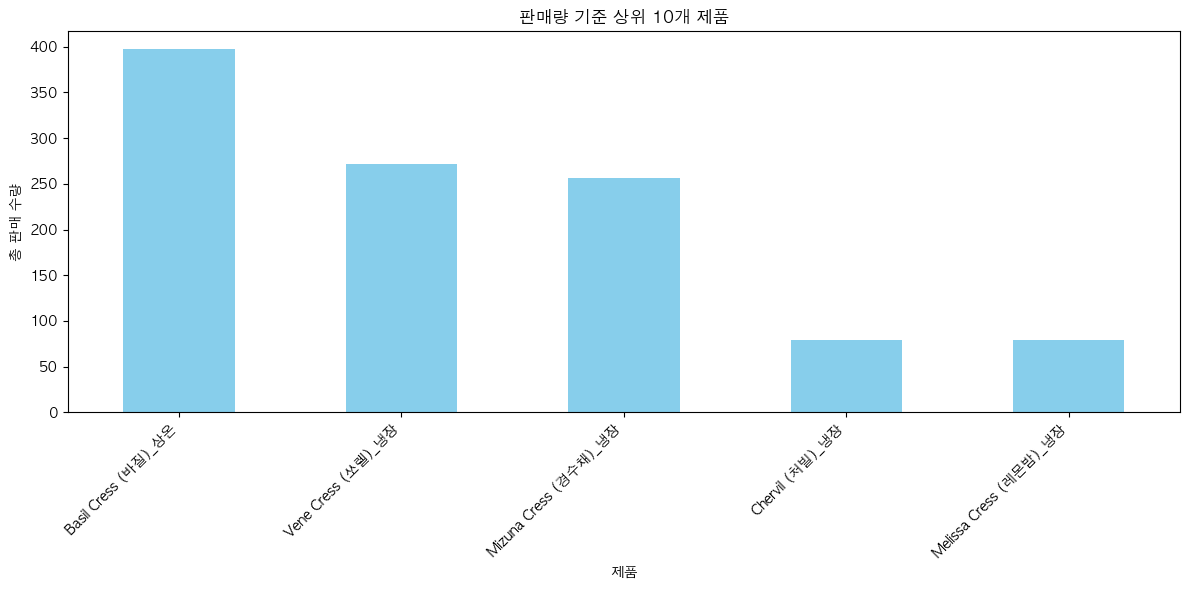

In [92]:
# 판매 상위 제품 시각화
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('판매량 기준 상위 10개 제품')
plt.xlabel('제품')
plt.ylabel('총 판매 수량')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_products.png')
plt.show()

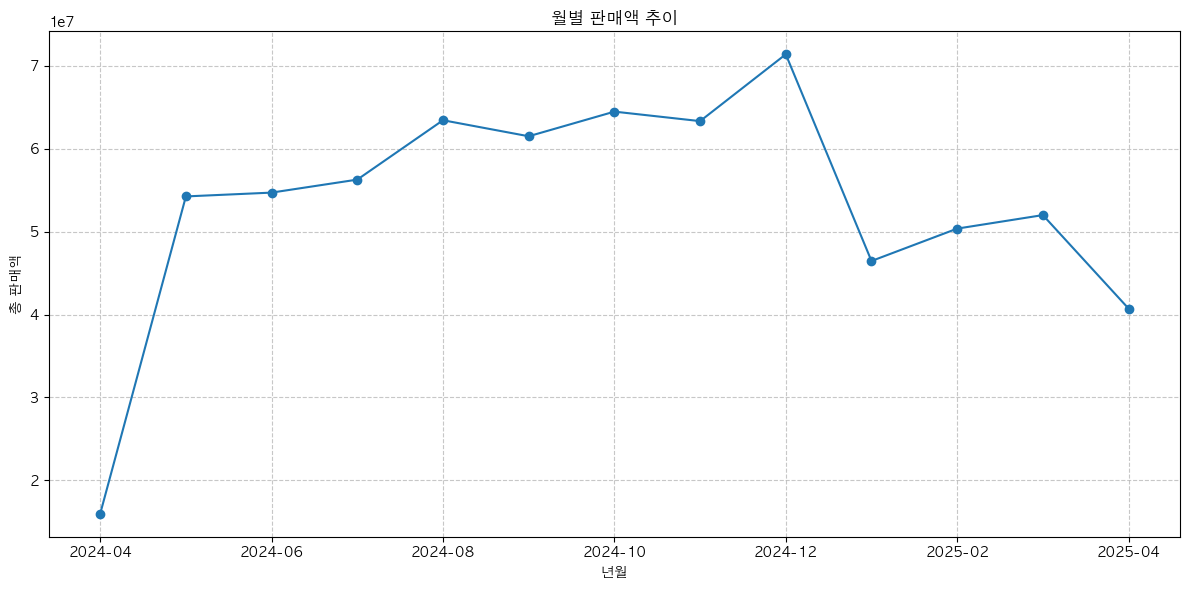

In [94]:
# 월별 판매 추이 시각화
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('월별 판매액 추이')
plt.xlabel('년월')
plt.ylabel('총 판매액')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('monthly_sales.png')
plt.show()

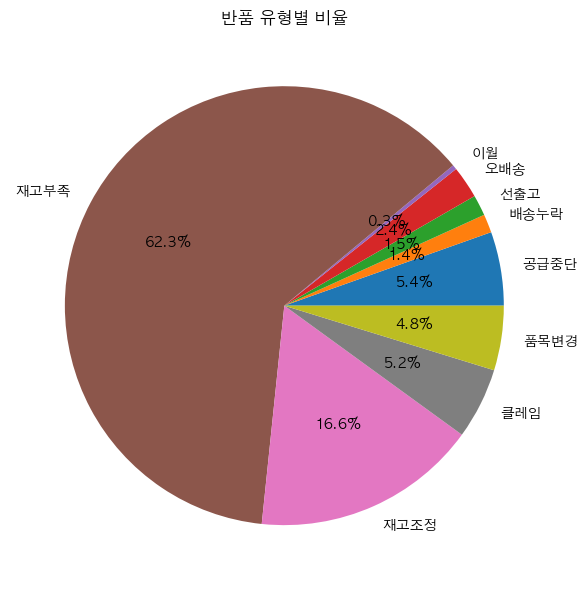

In [96]:
# 반품 유형 분석 시각화
plt.figure(figsize=(10, 6))
refund_by_type.abs().plot(kind='pie', autopct='%1.1f%%')
plt.title('반품 유형별 비율')
plt.ylabel('')
plt.tight_layout()
plt.savefig('return_types.png')
plt.show()

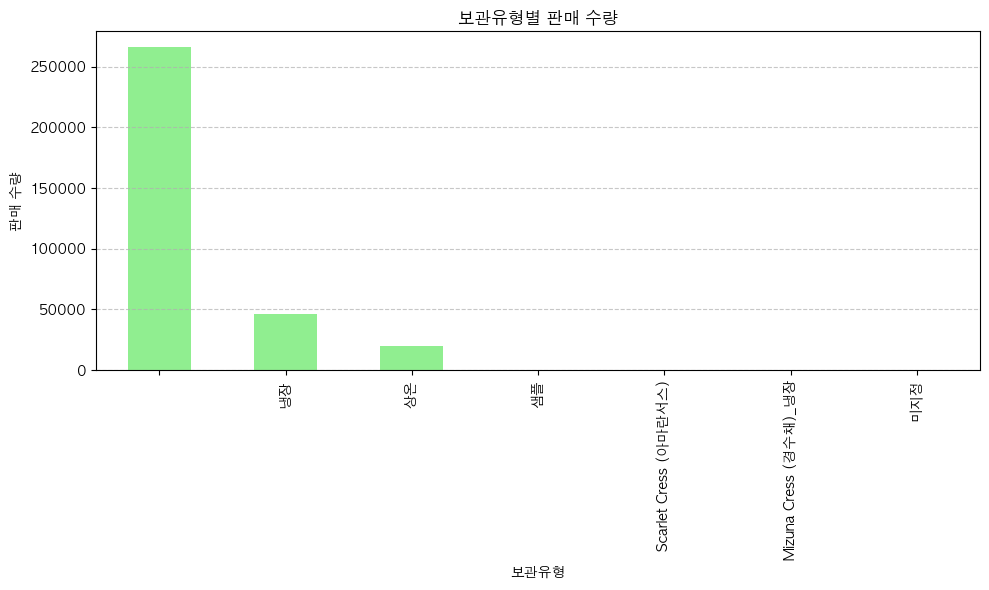

In [98]:
# 보관유형별 판매 분석 시각화
plt.figure(figsize=(10, 6))
storage_sales.plot(kind='bar', color='lightgreen')
plt.title('보관유형별 판매 수량')
plt.xlabel('보관유형')
plt.ylabel('판매 수량')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('storage_type_sales.png')
plt.show()

/var/folders/q2/_y_3vnwd37j_pj9njcz290gw0000gn/T/ipykernel_62037/3746057983.py:9: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/q2/_y_3vnwd37j_pj9njcz290gw0000gn/T/ipykernel_62037/3746057983.py:10: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) AppleGothic.
  plt.savefig('high_refund_ratio.png')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 174 (\N{REGISTERED SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


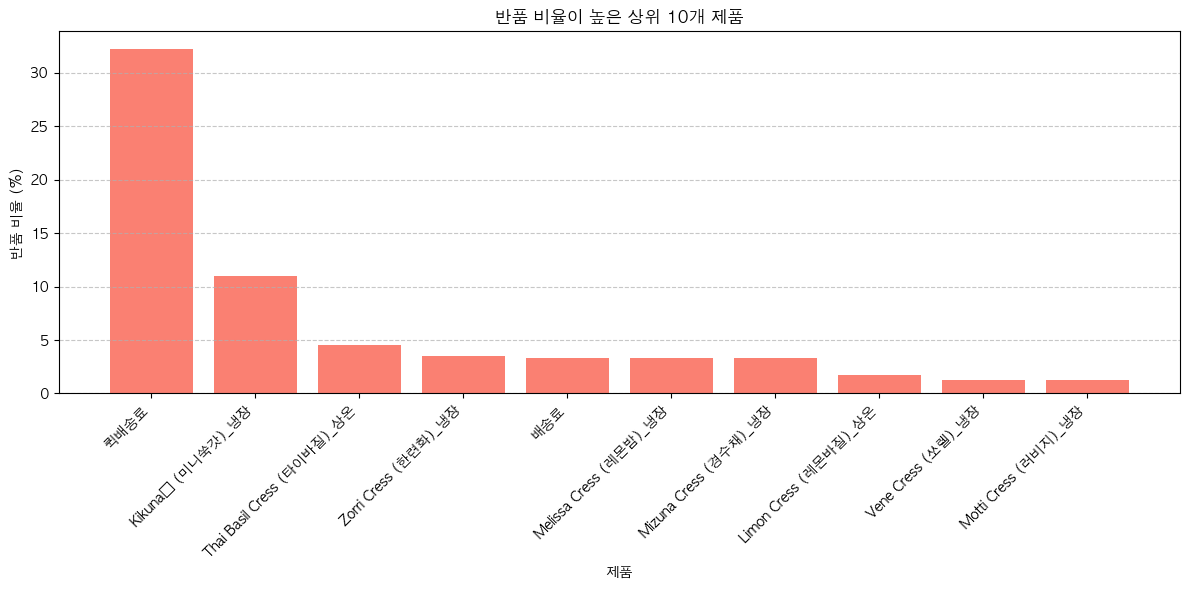

In [100]:
# 반품비율이 높은 품목들 시각화
plt.figure(figsize=(12, 6))
plt.bar(high_refund_ratio['품목'].head(10), high_refund_ratio['반품비율'].head(10), color='salmon')
plt.title('반품 비율이 높은 상위 10개 제품')
plt.xlabel('제품')
plt.ylabel('반품 비율 (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('high_refund_ratio.png')
plt.show()


# 6. 요일별/거래처별 분석

In [108]:
# 요일별 판매 패턴
sales_data['요일'] = sales_data['날짜'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = sales_data.groupby('요일')['합계'].sum()
daily_sales = daily_sales.reindex(day_order)
print("\n요일별 판매 패턴:\n")
print(daily_sales)


요일별 판매 패턴:

요일
Monday       147627250.0
Tuesday      119040000.0
Wednesday    132296000.0
Thursday     109011000.0
Friday       178112300.0
Saturday       7514000.0
Sunday         1296000.0
Name: 합계, dtype: float64


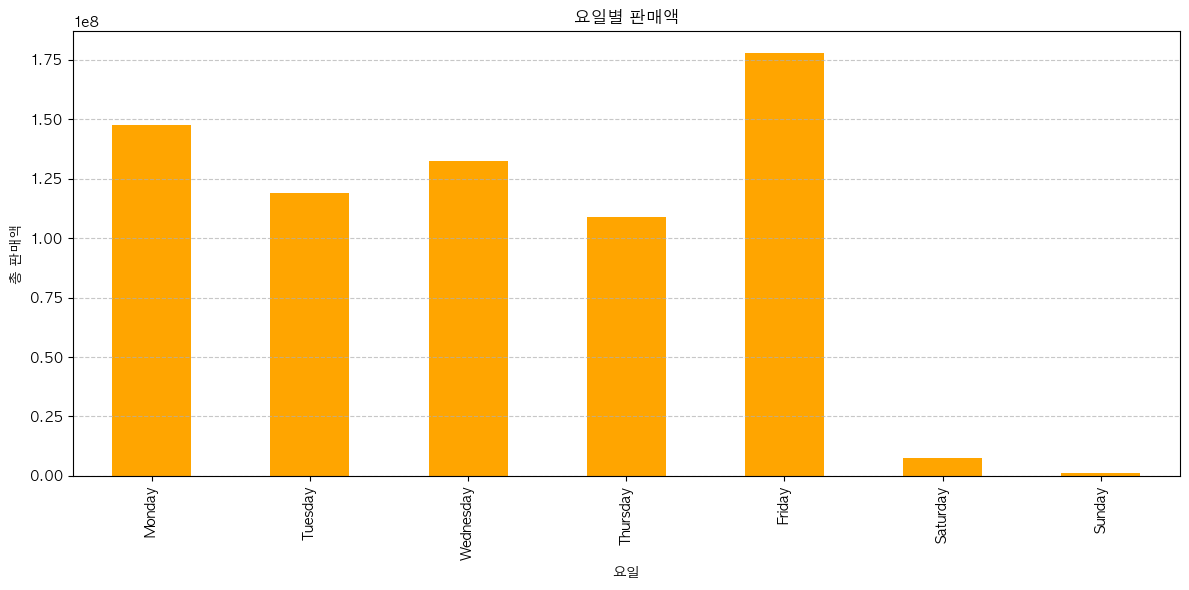

In [110]:
# 시각화: 요일별 판매액
plt.figure(figsize=(12, 6))
daily_sales.plot(kind='bar', color='orange')
plt.title('요일별 판매액')
plt.xlabel('요일')
plt.ylabel('총 판매액')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('daily_sales.png')
plt.show()

In [112]:
# 7. 비고(메모)에 따른 패턴 분석
common_notes = sales_data['비고'].value_counts().head(20)
print("\n9. 가장 빈번한 주문 비고(메모):")
print(common_notes)


9. 가장 빈번한 주문 비고(메모):
비고
Tamayura               565
BANQUET KITCHEN        556
Banquet Kitchen        500
Fait Maison Kitchen    335
9TH GATE KITCHEN       285
MARIPOSA Kitchen       275
Minagi                 266
Banquet                245
마이클스(조리)               226
Latitude32 Kitchen     192
라망시크레                  189
Voisin Kitchen         171
콜드 주방                  159
Pastry                 128
The Margaux Grill      111
MARIPOSA               100
COLD KITCHEN            97
Lobby Lounges           85
이타닉가든_주방                73
Banquets                73
Name: count, dtype: int64


# 7. 매출 최적화를 위한 인사이트

In [118]:
# 거래 그룹화
transaction_data = sales_data.groupby(['거래처', '날짜'])['품목'].apply(list).reset_index()

# 함께 구매되는 상품 쌍 추출 함수
def get_product_pairs(products):
    pairs = []
    products = [p for p in products if isinstance(p, str)]  # 문자열만 처리
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            pairs.append((products[i], products[j]))
            pairs.append((products[j], products[i]))
    return pairs

# 모든 거래에서 제품 쌍 추출
all_pairs = []
for transaction in transaction_data['품목']:
    all_pairs.extend(get_product_pairs(transaction))

# 가장 빈번하게 함께 구매되는 상품 쌍 찾기
pair_counts = Counter(all_pairs)
top_pairs = pd.DataFrame(pair_counts.most_common(31), columns=['제품 쌍', '함께 구매된 횟수'])

print("\n함께 자주 구매되는 상품 쌍:")
print(top_pairs)


함께 자주 구매되는 상품 쌍:
                                                 제품 쌍  함께 구매된 횟수
0   (Shiso Purple (적시소)_상온, Scarlet Cress (아마란서스)_냉장)       1280
1   (Scarlet Cress (아마란서스)_냉장, Shiso Purple (적시소)_상온)       1280
2       (Vene Cress (쏘렐)_냉장, Affilla® Cress (완두순)_냉장)       1190
3       (Affilla® Cress (완두순)_냉장, Vene Cress (쏘렐)_냉장)       1190
4      (Scarlet Cress (아마란서스)_냉장, Vene Cress (쏘렐)_냉장)       1189
5      (Vene Cress (쏘렐)_냉장, Scarlet Cress (아마란서스)_냉장)       1189
6        (Basil Cress (바질)_상온, Shiso Purple (적시소)_상온)       1154
7        (Shiso Purple (적시소)_상온, Basil Cress (바질)_상온)       1154
8         (Shiso Purple (적시소)_상온, Vene Cress (쏘렐)_냉장)       1051
9         (Vene Cress (쏘렐)_냉장, Shiso Purple (적시소)_상온)       1051
10   (Shiso Purple (적시소)_상온, Affilla® Cress (완두순)_냉장)        903
11   (Affilla® Cress (완두순)_냉장, Shiso Purple (적시소)_상온)        903
12          (Basil Cress (바질)_상온, Vene Cress (쏘렐)_냉장)        886
13          (Vene Cress (쏘렐)_냉장, Basil Cress (바질)_상온)        886
14    (

# 8. 고객 세분화

In [124]:
print("\n===== 고객 세분화 RFM 분석 결과 =====")
now = sales_data['날짜'].max()

rfm_data = sales_data.groupby('거래처').agg({
    '날짜': lambda x: (now - x.max()).days,  # Recency
    '거래처': 'count',  # Frequency
    '합계': 'sum'  # Monetary
}).rename(columns={'날짜': 'recency', '거래처': 'frequency', '합계': 'monetary'})

# RFM 점수 계산
rfm_data['R_score'] = pd.qcut(rfm_data['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_data['F_score'] = pd.qcut(rfm_data['frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_data['M_score'] = pd.qcut(rfm_data['monetary'], 5, labels=[1, 2, 3, 4, 5])

# 최종 RFM 점수 계산
rfm_data['RFM_score'] = rfm_data['R_score'].astype(int) + rfm_data['F_score'].astype(int) + rfm_data['M_score'].astype(int)

# 고객 분류
def classify_customer(score):
    if score >= 12:
        return 'VIP 고객'
    elif score >= 9:
        return '충성 고객'
    elif score >= 6:
        return '잠재 고객'
    else:
        return '이탈 위험 고객'

rfm_data['고객_세그먼트'] = rfm_data['RFM_score'].apply(classify_customer)

# pd.set_option을 사용하여 데이터프레임 출력 설정 변경
pd.set_option('display.max_rows', None)  # 모든 행 표시
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.width', 1000)  # 출력 너비 설정

# 세그먼트별 고객 수와 비율
segment_counts = rfm_data['고객_세그먼트'].value_counts()
segment_percents = rfm_data['고객_세그먼트'].value_counts(normalize=True) * 100

print("\n고객 세그먼트별 분포:")
for segment, count in segment_counts.items():
    percent = segment_percents[segment]
    print(f"{segment}: {count}개 업체 ({percent:.1f}%)")


===== 고객 세분화 RFM 분석 결과 =====

고객 세그먼트별 분포:
VIP 고객: 65개 업체 (31.6%)
이탈 위험 고객: 53개 업체 (25.7%)
충성 고객: 49개 업체 (23.8%)
잠재 고객: 39개 업체 (18.9%)


## 각 세그먼트별 전체 고객 정보

In [131]:
print("\n== VIP 고객 목록 ==")
vip_customers = rfm_data[rfm_data['고객_세그먼트'] == 'VIP 고객'].sort_values('monetary', ascending=False)
print(vip_customers[['recency', 'frequency', 'monetary', 'RFM_score']])


== VIP 고객 목록 ==
                       recency  frequency    monetary  RFM_score
거래처                                                             
001_포시즌스호텔                   1        727  98795000.0         15
001_소피텔                      1       1360  54662000.0         15
005_인스파이어인티그레이티드리조트          1        903  46893000.0         15
001_JW메리어트 동대문 스퀘어 서울        1        428  31708000.0         15
001_웨스틴조선호텔                  1        573  22003000.0         15
001_JW메리어트 서울                1        827  18225000.0         15
001_페어몬트호텔                   1        435  18142000.0         15
002_*신금유통                    0        564  17183000.0         15
002_주식회사 콘피에르                0        400  14890000.0         15
001_조선팰리스강남                  1        364  14465000.0         15
001_엠갤러리                     1        361  14031000.0         15
002_소설한남 CJ                  4        674  13426000.0         14
002_알라프리마(Alla prima)        1        185  12263000.0         15
002_#구찌오

In [133]:
print("\n== 충성 고객 목록 ==")
loyal_customers = rfm_data[rfm_data['고객_세그먼트'] == '충성 고객'].sort_values('monetary', ascending=False)
print(loyal_customers[['recency', 'frequency', 'monetary', 'RFM_score']])


== 충성 고객 목록 ==
                            recency  frequency   monetary  RFM_score
거래처                                                                 
002_바위파스타바                      109         96  3496300.0         11
002_#신선유통(가락)                    76        173  3396000.0         10
001_파르나스호텔                        8         89  2816000.0         11
002_강민철 레스토랑                     56        184  2627000.0         11
005_*현대자동차(주) 현대 모터스튜디오 부산       19         76  2400000.0         10
002_비채나                          54         47  2300000.0          9
002_롱씨암                          11         30  2051000.0          9
002_르쏠(LE SOL)                   76        100  2040000.0         10
002_독도16도                        11        171  1999000.0         11
002_이내서울                         48         94  1934000.0         10
002_소울다이닝                        14        133  1924000.0         11
002_라페름                           4         39  1912000.0         10
001_해비치 스패츌러      

In [135]:
print("\n== 잠재 고객 목록 ==")
potential_customers = rfm_data[rfm_data['고객_세그먼트'] == '잠재 고객'].sort_values('monetary', ascending=False)
print(potential_customers[['recency', 'frequency', 'monetary', 'RFM_score']])


== 잠재 고객 목록 ==
                      recency  frequency   monetary  RFM_score
거래처                                                           
002_디라운지 해방(폐업)           243         44  1644000.0          7
002_산(SAN) CJ              74         64  1612000.0          8
001_(주)조선호텔앤리조트 야마부키       36         39  1460000.0          7
005_#농업회사법인 사계절            12         35  1437000.0          8
002_킴보(KEEMBO)             96         41  1360000.0          8
002_띠엘로                    97         78  1252000.0          8
002_트리드(trid)              63         60  1156000.0          8
002_문화시민 서울               169         54  1068000.0          7
002_(주)농심 포리스트키친          230         74   996000.0          7
002_자르뎅페르뒤                 33         52   920000.0          8
002_트러플디알바                 97         32   844000.0          7
002_바제                    167         40   798000.0          7
002_센트럴윤잇                  70         28   796000.0          7
002_묘미                    326         6

In [137]:
print("\n== 이탈 위험 고객 목록 ==")
at_risk_customers = rfm_data[rfm_data['고객_세그먼트'] == '이탈 위험 고객'].sort_values('monetary', ascending=False)
print(at_risk_customers[['recency', 'frequency', 'monetary', 'RFM_score']])


== 이탈 위험 고객 목록 ==
                              recency  frequency  monetary  RFM_score
거래처                                                                  
003_*르도헤                          264         34  630000.0          5
003_고든램지버거 신세계센텀시티점               259         10  420000.0          5
002_알아차림 한남                       225         15  384000.0          5
002_사색연희                          319         10  372000.0          5
002_크림                            151         22  336000.0          5
002_오름                            270         20  225000.0          5
002_루미노 다이닝바                       46          7  196000.0          5
002_클레어 파티시에                      256         22  192000.0          5
002_엘라보레                          264         16  192000.0          5
002_가루하루                          340          9  180000.0          4
001_(주)조선호텔앤리조트 하나클럽              153          3  144000.0          4
002_다토(DATO)                      246          7  144000.0          4
0

In [139]:
# 세그먼트별 평균 Recency, Frequency, Monetary 값 계산
segment_stats = rfm_data.groupby('고객_세그먼트').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(1)

print("\n세그먼트별 평균 지표:")
print(segment_stats)


세그먼트별 평균 지표:
          recency  frequency   monetary
고객_세그먼트                                
VIP 고객        3.4      281.0  9093180.8
이탈 위험 고객    172.5        7.0   117849.1
잠재 고객        73.1       32.8   669410.3
충성 고객        21.8      103.4  1458914.3


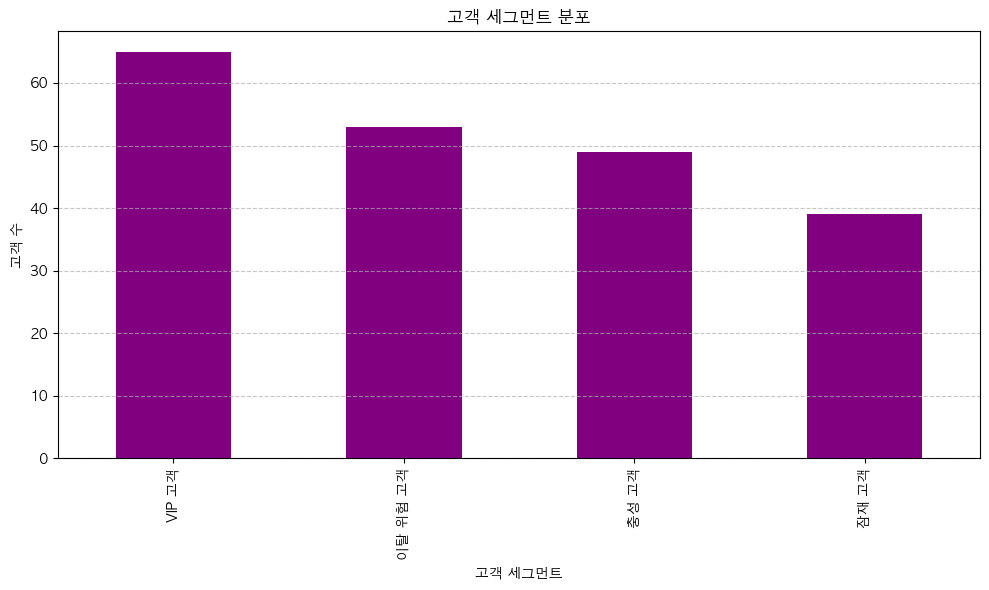

In [141]:
# 고객 세그먼트 시각화
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', color='purple')
plt.title('고객 세그먼트 분포')
plt.xlabel('고객 세그먼트')
plt.ylabel('고객 수')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('customer_segments.png')
plt.show()

# 9. 계절성 분석


===== 계절성 분석 =====


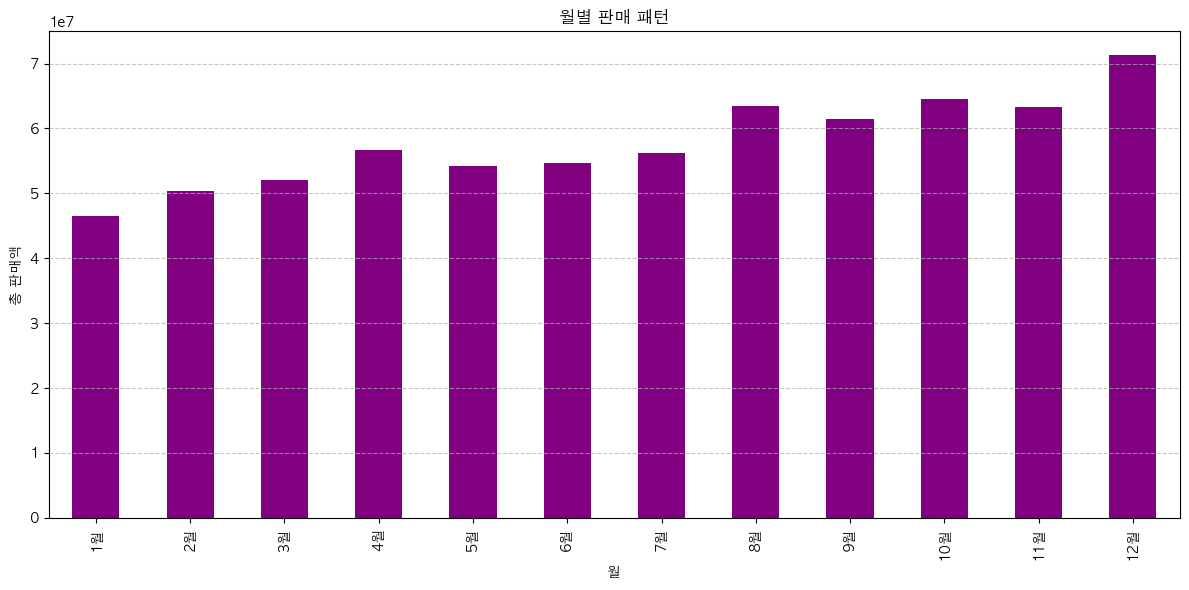

In [143]:
print("\n===== 계절성 분석 =====")
sales_data['month'] = sales_data['날짜'].dt.month
monthly_pattern = sales_data.groupby('month')['합계'].sum()

month_names = ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']

plt.figure(figsize=(12, 6))
monthly_pattern.plot(kind='bar', color='purple')
plt.title('월별 판매 패턴')
plt.xlabel('월')
plt.ylabel('총 판매액')
plt.xticks(range(12), month_names)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('monthly_pattern.png')
plt.show()

In [145]:
print("\n계절성이 높은 제품 (월별 판매량 변동성):")
# 월별 제품 판매량 시계열 분석
top_seasonal_products = []

monthly_product_sales = sales_data.groupby(['month', '품목'])['수량'].sum().reset_index()
pivot_monthly_sales = monthly_product_sales.pivot(index='품목', columns='month', values='수량').fillna(0)

for product in pivot_monthly_sales.index:
    if pivot_monthly_sales.loc[product].sum() > 10:  # 판매량이 충분한 제품만 고려
        monthly_sales = pivot_monthly_sales.loc[product].tolist()
        
        # 계절성 지표 계산 (표준편차/평균)
        seasonality = np.std(monthly_sales) / (np.mean(monthly_sales) + 1)
        top_seasonal_products.append((product, seasonality))

seasonal_df = pd.DataFrame(top_seasonal_products, columns=['제품', '계절성_지표']).sort_values('계절성_지표', ascending=False)
print(seasonal_df.head(10))


계절성이 높은 제품 (월별 판매량 변동성):
                            제품    계절성_지표
27      [Test]_Chervil (처빌)_샘플  2.187561
0   (큰잎) Scarlet Cress (아마란서스)  1.513825
28                         배송료  1.314896
11           Kikuna® (미니쑥갓)_냉장  1.096740
26        Zorri Cress (한련화)_냉장  1.018665
6              Chervil (처빌)_냉장  0.704189
29                         배송비  0.596263
30             사쿠라® (Sango)_냉장  0.557302
15        Motti Cress (러비지)_냉장  0.383656
4        Borage Cress (보리지)_냉장  0.355413


# 10. 주요 거래처별 선호 제품

In [156]:
print("\n주요 거래처별 선호 제품:")
for customer in customer_sales.head(3).index:
    top_products = sales_data[sales_data['거래처'] == customer].groupby('품목')['수량'].sum().sort_values(ascending=False).head(5)
    print(f"\n{customer}의 선호 제품 TOP 5:")
    print(top_products)

# 설정 초기화
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')



주요 거래처별 선호 제품:

001_포시즌스호텔의 선호 제품 TOP 5:
품목
Shiso Purple (적시소)_상온         1900.0
Persinette® Cress (파슬리)_냉장    1848.0
Rucola Cress (루꼴라)_냉장         1827.0
Scarlet Cress (아마란서스)_냉장      1804.0
Basil Cress (바질)_상온            372.0
Name: 수량, dtype: float64

001_소피텔의 선호 제품 TOP 5:
품목
Affilla® Cress (완두순)_냉장    1063.0
Basil Cress (바질)_상온         837.0
Rucola Cress (루꼴라)_냉장       626.0
Shiso Purple (적시소)_상온       611.0
Vene Cress (쏘렐)_냉장          405.0
Name: 수량, dtype: float64

005_인스파이어인티그레이티드리조트의 선호 제품 TOP 5:
품목
Mizuna Cress (경수채)_냉장       858.0
Scarlet Cress (아마란서스)_냉장    585.0
Basil Cress (바질)_상온         525.0
Shiso Purple (적시소)_상온       467.0
Vene Cress (쏘렐)_냉장          239.0
Name: 수량, dtype: float64


# 11. 품목별 월별 판매 패턴 분석

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import platform

# 기본 데이터 준비 함수
def prepare_monthly_product_data():
    """월별 제품 판매량 데이터를 준비하는 함수"""
    # 월별 제품 판매량 피벗 테이블 생성
    monthly_product_sales = sales_data.groupby(['month', '품목'])['수량'].sum().reset_index()
    pivot_table = monthly_product_sales.pivot(index='품목', columns='month', values='수량').fillna(0)
    
    # 모든 월을 포함하도록 데이터 조정 (1-12월)
    for month in range(1, 13):
        if month not in pivot_table.columns:
            pivot_table[month] = 0
    pivot_table = pivot_table.reindex(columns=range(1, 13))
    
    # 상위 제품 목록
    top_products = sales_data.groupby('품목')['수량'].sum().nlargest(10).index.tolist()
    top20_products = sales_data.groupby('품목')['수량'].sum().nlargest(20).index.tolist()
    
    return {
        'pivot_table': pivot_table,
        'monthly_product_sales': monthly_product_sales,
        'top_products': top_products,
        'top20_products': top20_products
    }


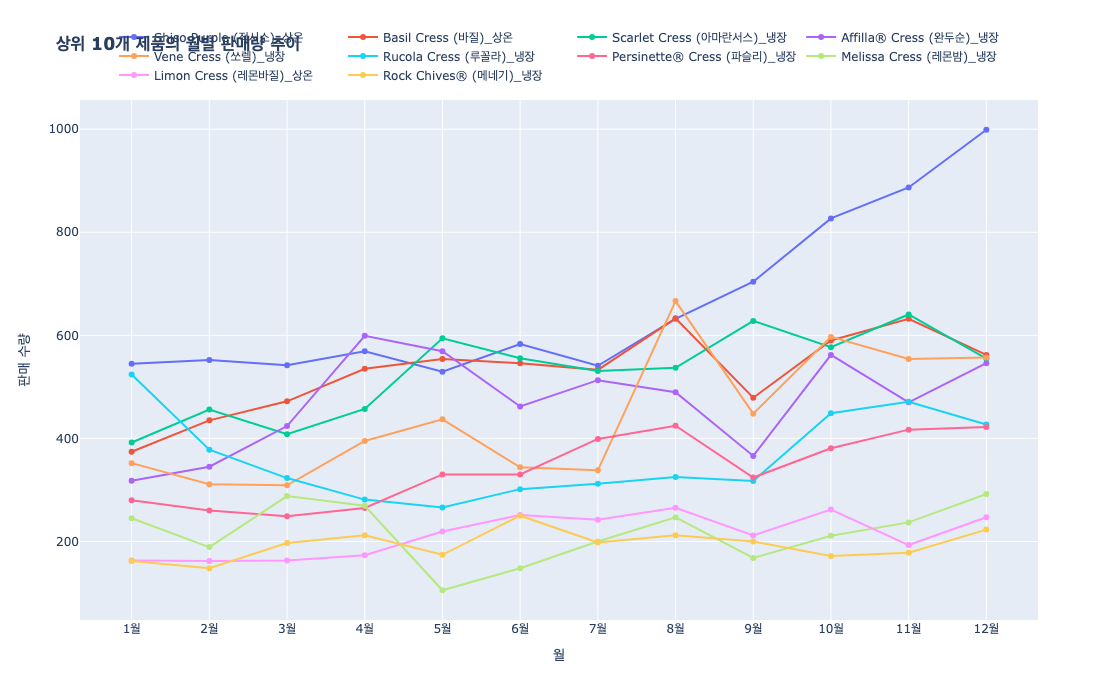

In [272]:
def visualize_top_products_trend():
    """상위 10개 제품의 월별 판매량 추이를 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    top_products = data['top_products']
    
    fig = go.Figure()
    
    for product in top_products:
        if product in pivot_table.index:
            fig.add_trace(go.Scatter(
                x=list(range(1, 13)), 
                y=pivot_table.loc[product].tolist(),
                mode='lines+markers',
                name=product,
                hovertemplate='%{y:.1f}개<extra>' + product + ' (%{x}월)</extra>'
            ))
    
    fig.update_layout(
        title='<b>상위 10개 제품의 월별 판매량 추이</b>',
        xaxis_title='월',
        yaxis_title='판매 수량',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 13)),
            ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        ),
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        width=1200,
        height=700
    )
    
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_top_products_trend()


히트맵에 표시된 제품 수: 20


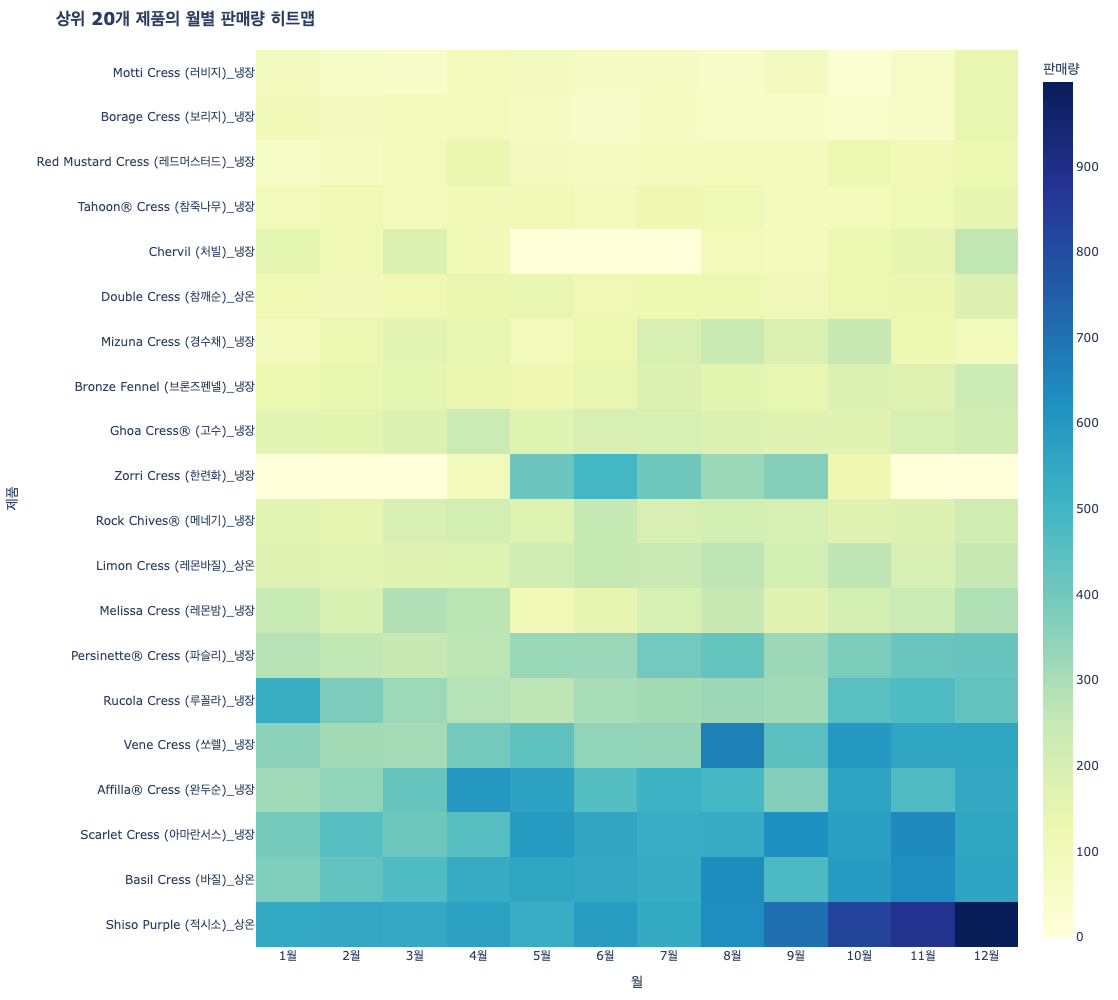

In [274]:
def visualize_top_products_heatmap():
    """상위 20개 제품의 월별 판매량 히트맵 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    top20_products = data['top20_products']
    
    # 상위 20개 제품으로 제한하여 가독성 향상
    pivot_subset = pivot_table.loc[top20_products]
    
    # 히트맵을 위한 데이터 준비
    z_vals = pivot_subset.values
    hover_text = []
    for i, product in enumerate(pivot_subset.index):
        hover_text.append([])
        for j, month in enumerate(range(1, 13)):
            hover_text[-1].append(f'{product}<br>월: {month}월<br>판매량: {z_vals[i][j]:.1f}개')
    
    fig = go.Figure(data=go.Heatmap(
        z=z_vals,
        x=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'],
        y=pivot_subset.index,
        hoverongaps=False,
        hoverinfo='text',
        text=hover_text,
        colorscale='YlGnBu',
        colorbar=dict(title='판매량')
    ))
    
    fig.update_layout(
        title='<b>상위 20개 제품의 월별 판매량 히트맵</b>',
        xaxis_title='월',
        yaxis_title='제품',
        width=1200,
        height=1000,
        margin=dict(l=150, r=50, t=50, b=50)  # 왼쪽 여백을 늘려서 제품명이 잘리지 않도록 함
    )
    
    print(f"히트맵에 표시된 제품 수: {len(pivot_subset)}")
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_top_products_heatmap()



계절성이 가장 높은 10개 제품:
1. [Test]_Chervil (처빌)_샘플 - 계절성 지표: 2.19, 최대 판매월: 7월
2. 배송료 - 계절성 지표: 1.31, 최대 판매월: 4월
3. Kikuna® (미니쑥갓)_냉장 - 계절성 지표: 1.10, 최대 판매월: 5월
4. Zorri Cress (한련화)_냉장 - 계절성 지표: 1.02, 최대 판매월: 6월
5. Chervil (처빌)_냉장 - 계절성 지표: 0.70, 최대 판매월: 12월
6. 사쿠라® (Sango)_냉장 - 계절성 지표: 0.56, 최대 판매월: 1월
7. Motti Cress (러비지)_냉장 - 계절성 지표: 0.38, 최대 판매월: 12월
8. Borage Cress (보리지)_냉장 - 계절성 지표: 0.36, 최대 판매월: 12월
9. Mizuna Cress (경수채)_냉장 - 계절성 지표: 0.35, 최대 판매월: 10월
10. Honny® Cress (스테비아)_냉장 - 계절성 지표: 0.34, 최대 판매월: 12월


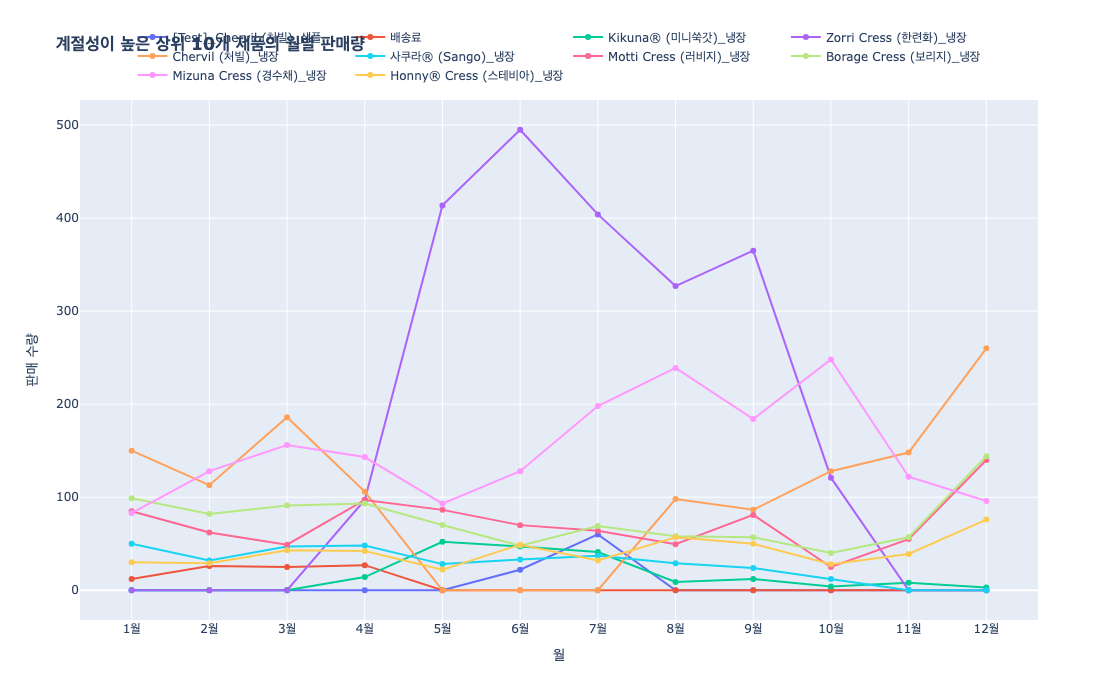

In [276]:
def visualize_seasonal_products():
    """계절성이 높은 상위 10개 제품의 월별 판매량을 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    
    # 계절성 계산 함수
    def calculate_seasonality(sales_array):
        """판매량 배열에서 계절성 지표 계산 (표준편차/평균)"""
        if np.mean(sales_array) > 0:
            return np.std(sales_array) / (np.mean(sales_array) + 1)
        else:
            return 0
    
    # 모든 제품에 대한 계절성 계산
    seasonal_products = []
    for product in pivot_table.index:
        monthly_sales = pivot_table.loc[product].values
        # 총 판매량이 일정 이상인 제품만 고려
        if np.sum(monthly_sales) > 20:
            seasonality = calculate_seasonality(monthly_sales)
            peak_month = pivot_table.loc[product].idxmax()  # 최대 판매월
            seasonal_products.append((product, seasonality, peak_month, np.sum(monthly_sales)))
    
    # 계절성이 높은 상위 10개 제품
    seasonal_df = pd.DataFrame(seasonal_products, 
                           columns=['제품', '계절성_지표', '최대_판매월', '총_판매량']).sort_values('계절성_지표', ascending=False)
    
    high_seasonal_products = seasonal_df.head(10)['제품'].tolist()
    
    fig = go.Figure()
    
    for product in high_seasonal_products:
        if product in pivot_table.index:
            fig.add_trace(go.Scatter(
                x=list(range(1, 13)), 
                y=pivot_table.loc[product].tolist(),
                mode='lines+markers',
                name=product,
                hovertemplate='%{y:.1f}개<extra>' + product + ' (%{x}월)</extra>'
            ))
    
    fig.update_layout(
        title='<b>계절성이 높은 상위 10개 제품의 월별 판매량</b>',
        xaxis_title='월',
        yaxis_title='판매 수량',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 13)),
            ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        ),
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        width=1200,
        height=700
    )
    
    # 계절성이 높은 제품 정보 출력
    print("\n계절성이 가장 높은 10개 제품:")
    for i, (_, row) in enumerate(seasonal_df.head(10).iterrows(), 1):
        print(f"{i}. {row['제품']} - 계절성 지표: {row['계절성_지표']:.2f}, 최대 판매월: {row['최대_판매월']}월")
    
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_seasonal_products()


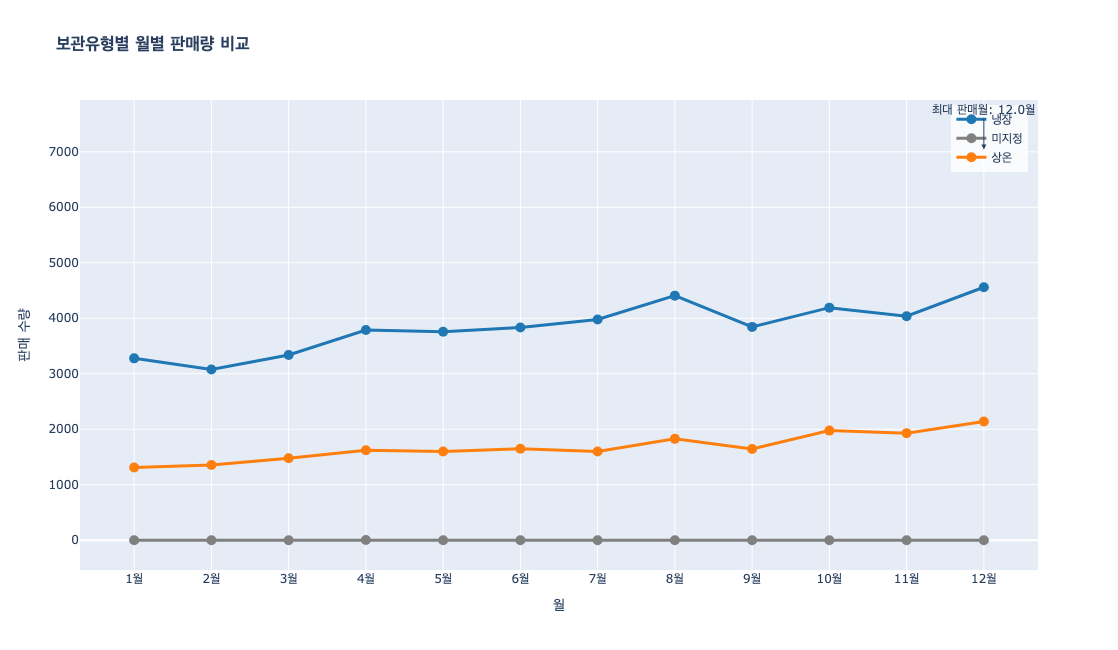

In [278]:
def visualize_storage_type_monthly():
    """보관유형별 월별 판매량을 비교 시각화"""
    # 보관유형별 월별 판매량 계산
    storage_monthly_sales = sales_data.groupby(['month', '보관유형'])['수량'].sum().reset_index()
    storage_pivot = storage_monthly_sales.pivot(index='보관유형', columns='month', values='수량').fillna(0)
    
    # 모든 월을 포함하도록 데이터 조정
    for month in range(1, 13):
        if month not in storage_pivot.columns:
            storage_pivot[month] = 0
    storage_pivot = storage_pivot.reindex(columns=range(1, 13))
    
    # 보관유형별 색상 지정
    colors = {'상온': 'rgb(255, 127, 14)', '냉장': 'rgb(31, 119, 180)', '미지정': 'rgb(128, 128, 128)'}
    
    fig = go.Figure()
    
    # 주요 보관유형 데이터 추가
    for storage_type in storage_pivot.index:
        if storage_type in ['상온', '냉장', '미지정']:
            fig.add_trace(go.Scatter(
                x=list(range(1, 13)), 
                y=storage_pivot.loc[storage_type].tolist(),
                mode='lines+markers',
                name=storage_type,
                line=dict(color=colors.get(storage_type, 'gray'), width=3),
                marker=dict(size=10),
                hovertemplate='<b>%{y:.1f}개</b><extra>' + storage_type + ' (%{x}월)</extra>'
            ))
    
    # 월별 총 판매량 계산
    monthly_total = storage_monthly_sales.groupby('month')['수량'].sum()
    
    # 최대 판매월 구하기
    annotations = []
    if len(monthly_total) > 0:
        max_month = monthly_total.idxmax()
        annotations.append(
            dict(
                x=max_month,
                y=monthly_total.max() * 1.05,
                xref="x",
                yref="y",
                text=f"최대 판매월: {max_month}월",
                showarrow=True,
                arrowhead=2,
                ax=0,
                ay=-40
            )
        )
    
    fig.update_layout(
        title='<b>보관유형별 월별 판매량 비교</b>',
        xaxis_title='월',
        yaxis_title='판매 수량',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 13)),
            ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        ),
        hovermode='x unified',
        width=1100,
        height=650,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        annotations=annotations
    )
    
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_storage_type_monthly()



=== 보관유형별 월별 판매량 ===


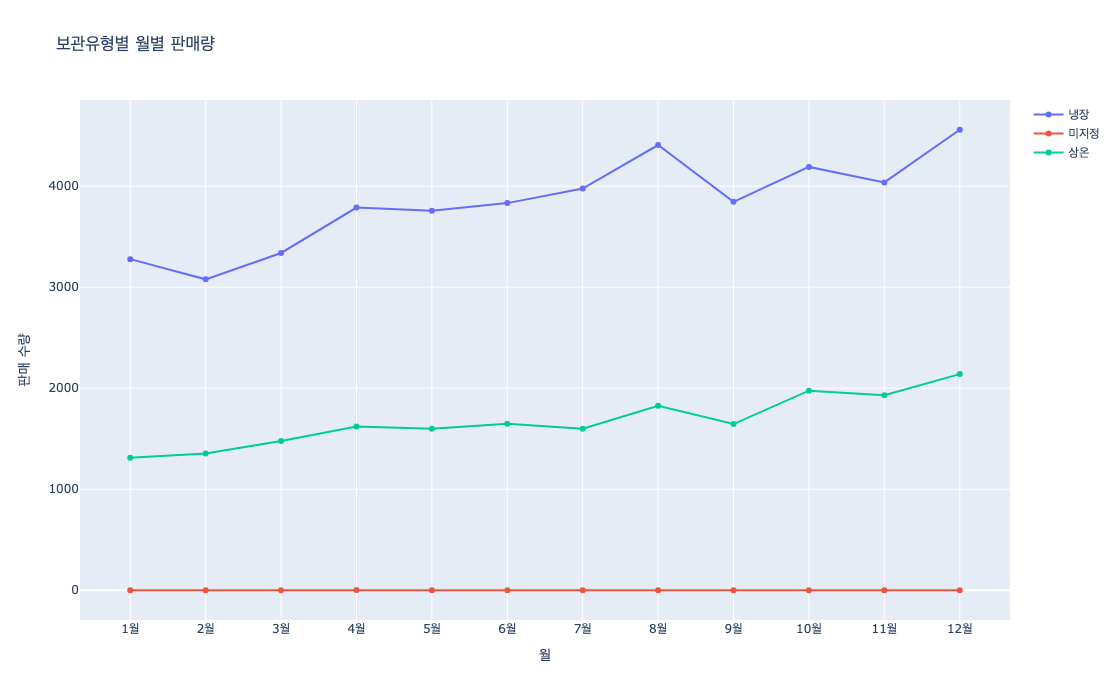

In [213]:
# 5. 보관유형별 월별 판매량
def show_storage_type_monthly():
    """보관유형별 월별 판매량을 보여주는 인터랙티브 라인 차트"""
    print("\n=== 보관유형별 월별 판매량 ===")
    
    # 보관유형별 월별 판매량 계산
    storage_monthly_sales = sales_data.groupby(['month', '보관유형'])['수량'].sum().reset_index()
    storage_pivot = storage_monthly_sales.pivot(index='보관유형', columns='month', values='수량').fillna(0)
    
    # 모든 월을 포함하도록 데이터 조정
    for month in range(1, 13):
        if month not in storage_pivot.columns:
            storage_pivot[month] = 0
    storage_pivot = storage_pivot.reindex(columns=range(1, 13))
    
    fig = go.Figure()
    
    for storage_type in storage_pivot.index:
        if storage_type in ['상온', '냉장', '미지정']:  # 주요 보관유형만 표시
            fig.add_trace(go.Scatter(
                x=list(range(1, 13)), 
                y=storage_pivot.loc[storage_type].tolist(),
                mode='lines+markers',
                name=storage_type,
                hovertemplate='%{y:.1f}개<extra>' + storage_type + ' (%{x}월)</extra>'
            ))
    
    fig.update_layout(
        title='보관유형별 월별 판매량',
        xaxis_title='월',
        yaxis_title='판매 수량',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 13)),
            ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        ),
        hovermode='x unified',
        width=1100,
        height=700
    )
    
    return fig
fig = show_storage_type_monthly() 

fig.show()


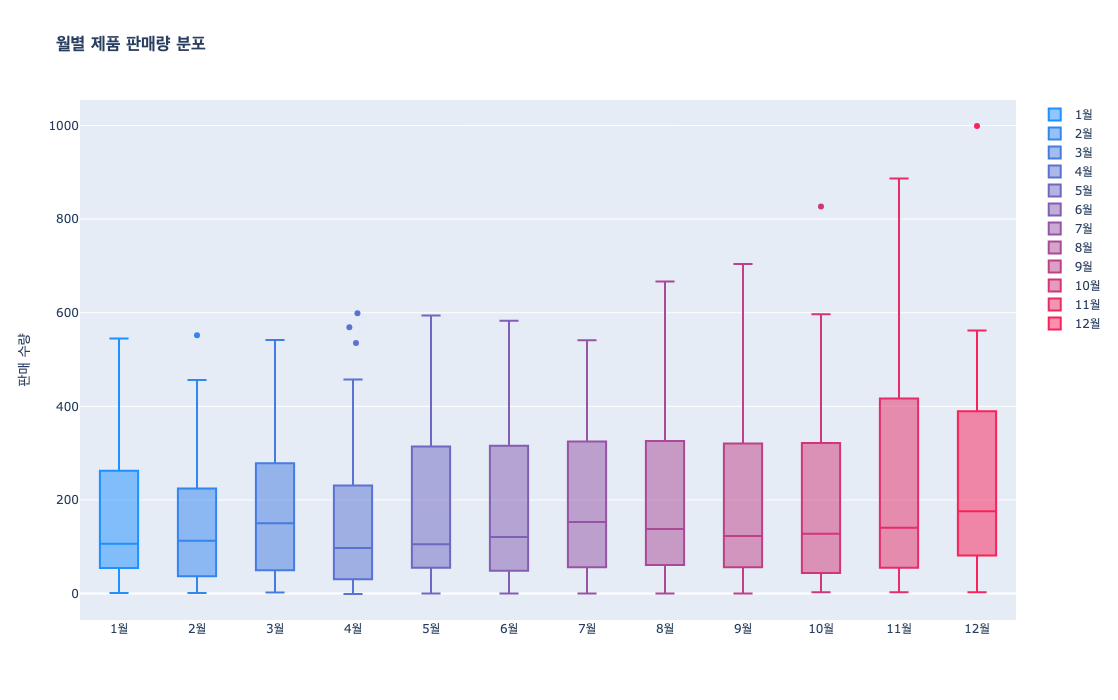

In [280]:
def visualize_monthly_distribution():
    """월별 제품 판매량 분포를 박스플롯으로 시각화"""
    data = prepare_monthly_product_data()
    monthly_product_sales = data['monthly_product_sales']
    
    monthly_dist_data = []
    for month in range(1, 13):
        if month in monthly_product_sales['month'].values:
            month_data = monthly_product_sales[monthly_product_sales['month'] == month]
            monthly_dist_data.append(month_data['수량'].tolist())
        else:
            monthly_dist_data.append([])
    
    fig = go.Figure()
    
    for i, month in enumerate(range(1, 13)):
        if monthly_dist_data[i]:
            fig.add_trace(go.Box(
                y=monthly_dist_data[i],
                name=f'{month}월',
                boxpoints='outliers',
                jitter=0.3,
                hoverinfo='y',
                marker_color=f'rgb{30+i*20, 144-i*10, 255-i*15}'
            ))
    
    fig.update_layout(
        title='<b>월별 제품 판매량 분포</b>',
        yaxis_title='판매 수량',
        hovermode='closest',
        width=1100,
        height=700
    )
    
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_monthly_distribution()


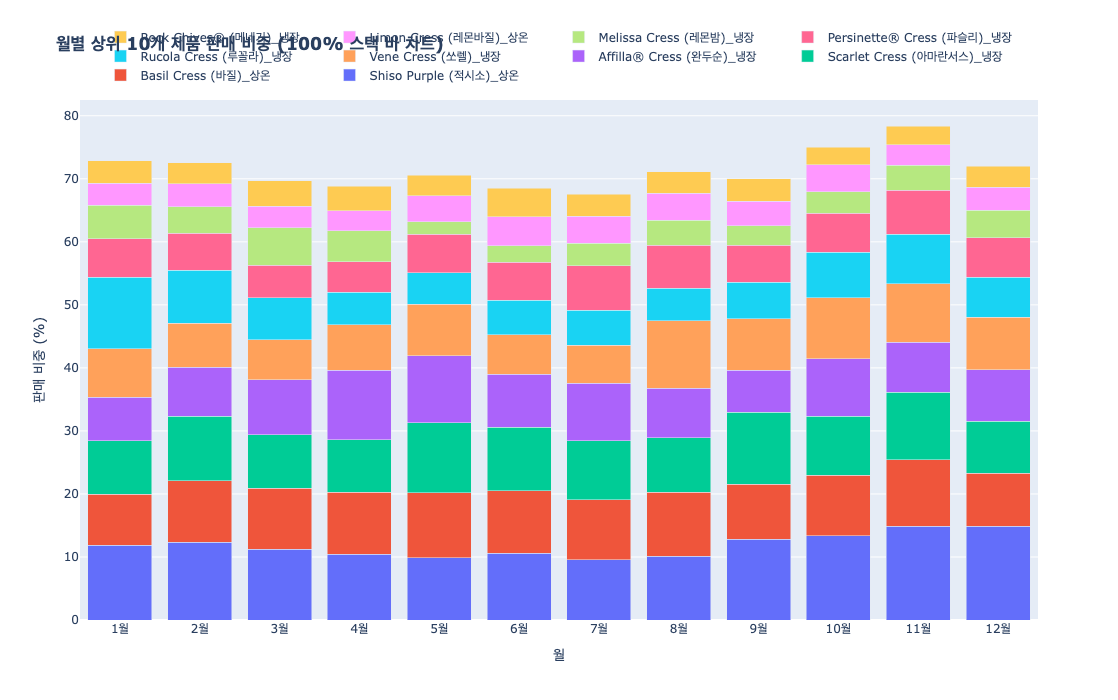

In [282]:
def visualize_monthly_product_share():
    """월별 상위 10개 제품의 판매 비중을 스택 바차트로 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    top_products = data['top_products']
    
    monthly_total = sales_data.groupby('month')['수량'].sum().reindex(range(1, 13)).fillna(0)
    
    # 색상 팔레트 설정
    colors = px.colors.qualitative.Plotly
    
    fig = go.Figure()
    
    # 상위 10개 제품에 대해 월별 비중 시각화
    for i, product in enumerate(top_products):
        if product in pivot_table.index:
            monthly_pct = []
            for month in range(1, 13):
                if monthly_total[month] > 0:
                    pct = pivot_table.loc[product, month] / monthly_total[month] * 100
                else:
                    pct = 0
                monthly_pct.append(pct)
                
            fig.add_trace(go.Bar(
                x=list(range(1, 13)),
                y=monthly_pct,
                name=product,
                marker_color=colors[i % len(colors)],
                hovertemplate='<b>%{y:.1f}%</b><extra>' + product + ' (%{x}월)</extra>'
            ))
    
    fig.update_layout(
        title='<b>월별 상위 10개 제품 판매 비중 (100% 스택 바 차트)</b>',
        xaxis_title='월',
        yaxis_title='판매 비중 (%)',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 13)),
            ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        ),
        barmode='stack',
        hovermode='closest',
        width=1100,
        height=700,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )
    
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_monthly_product_share()


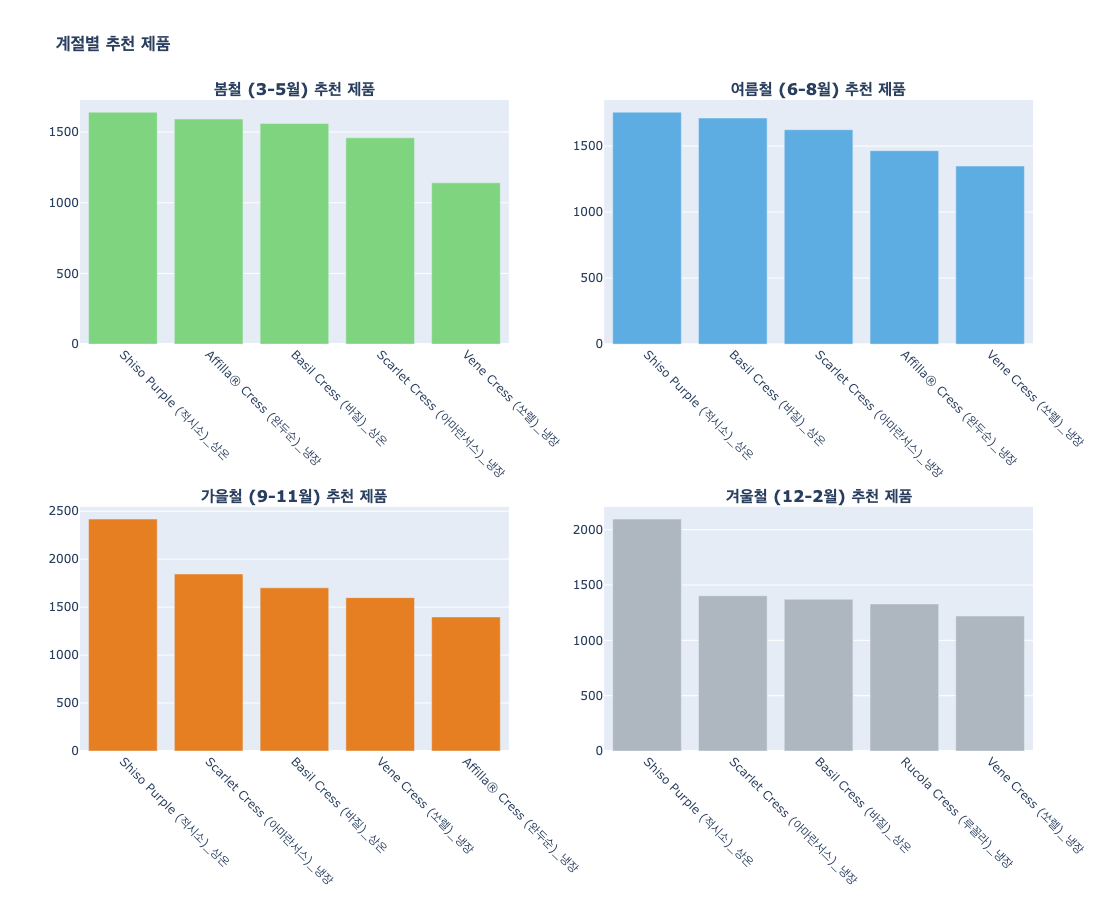


계절별 추천 제품 TOP 5:

봄철 (3-5월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 봄철 판매량: 1640.4개
2. Affilla® Cress (완두순)_냉장 - 봄철 판매량: 1592.2개
3. Basil Cress (바질)_상온 - 봄철 판매량: 1561.3개
4. Scarlet Cress (아마란서스)_냉장 - 봄철 판매량: 1459.3개
5. Vene Cress (쏘렐)_냉장 - 봄철 판매량: 1141.1개

여름철 (6-8월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 여름철 판매량: 1756.0개
2. Basil Cress (바질)_상온 - 여름철 판매량: 1712.0개
3. Scarlet Cress (아마란서스)_냉장 - 여름철 판매량: 1623.5개
4. Affilla® Cress (완두순)_냉장 - 여름철 판매량: 1464.5개
5. Vene Cress (쏘렐)_냉장 - 여름철 판매량: 1348.3개

가을철 (9-11월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 가을철 판매량: 2418.0개
2. Scarlet Cress (아마란서스)_냉장 - 가을철 판매량: 1845.5개
3. Basil Cress (바질)_상온 - 가을철 판매량: 1701.0개
4. Vene Cress (쏘렐)_냉장 - 가을철 판매량: 1599.0개
5. Affilla® Cress (완두순)_냉장 - 가을철 판매량: 1398.0개

겨울철 (12-2월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 겨울철 판매량: 2096.0개
2. Scarlet Cress (아마란서스)_냉장 - 겨울철 판매량: 1403.0개
3. Basil Cress (바질)_상온 - 겨울철 판매량: 1371.0개
4. Rucola Cress (루꼴라)_냉장 - 겨울철 판매량: 1329.0개
5. Vene Cress (쏘렐)_냉장 - 겨울철 판매량: 1220.0개


In [284]:
def visualize_seasonal_recommendations():
    """계절별 추천 제품을 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    
    # 계절 정의 (봄: 3-5월, 여름: 6-8월, 가을: 9-11월, 겨울: 12-2월)
    spring_months = [3, 4, 5]
    summer_months = [6, 7, 8]
    autumn_months = [9, 10, 11]
    winter_months = [12, 1, 2]
    
    # 계절별 총 판매량이 높은 제품 파악
    seasonal_best = {}
    for product in pivot_table.index:
        spring_sales = sum([pivot_table.loc[product, m] for m in spring_months if m in pivot_table.columns])
        summer_sales = sum([pivot_table.loc[product, m] for m in summer_months if m in pivot_table.columns])
        autumn_sales = sum([pivot_table.loc[product, m] for m in autumn_months if m in pivot_table.columns])
        winter_sales = sum([pivot_table.loc[product, m] for m in winter_months if m in pivot_table.columns])
        
        total_sales = spring_sales + summer_sales + autumn_sales + winter_sales
        if total_sales > 10:  # 판매량이 일정 이상인 경우만 고려
            seasonal_best[product] = {
                '봄': spring_sales,
                '여름': summer_sales,
                '가을': autumn_sales,
                '겨울': winter_sales,
                '총판매량': total_sales
            }
    
    seasonal_df = pd.DataFrame(seasonal_best).T
    seasonal_df['주요계절'] = seasonal_df[['봄', '여름', '가을', '겨울']].idxmax(axis=1)
    
    # 계절별 상위 제품 추출
    spring_best = seasonal_df.sort_values('봄', ascending=False).head(5)
    summer_best = seasonal_df.sort_values('여름', ascending=False).head(5)
    autumn_best = seasonal_df.sort_values('가을', ascending=False).head(5)
    winter_best = seasonal_df.sort_values('겨울', ascending=False).head(5)
    
    # 계절별 색상 정의
    season_colors = {
        '봄': '#7FD47F',  # 밝은 녹색
        '여름': '#5DADE2',  # 하늘색
        '가을': '#E67E22',  # 주황색
        '겨울': '#AEB6BF'   # 회색빛 파랑
    }
    
    fig = make_subplots(rows=2, cols=2, subplot_titles=(
        "<b>봄철 (3-5월) 추천 제품</b>", 
        "<b>여름철 (6-8월) 추천 제품</b>", 
        "<b>가을철 (9-11월) 추천 제품</b>", 
        "<b>겨울철 (12-2월) 추천 제품</b>"
    ))
    
    # 봄철 상위 제품
    fig.add_trace(
        go.Bar(
            x=spring_best.index, 
            y=spring_best['봄'], 
            name="봄철 판매량",
            marker_color=season_colors['봄'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=1, col=1
    )
    
    # 여름철 상위 제품
    fig.add_trace(
        go.Bar(
            x=summer_best.index, 
            y=summer_best['여름'], 
            name="여름철 판매량",
            marker_color=season_colors['여름'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=1, col=2
    )
    
    # 가을철 상위 제품
    fig.add_trace(
        go.Bar(
            x=autumn_best.index, 
            y=autumn_best['가을'], 
            name="가을철 판매량",
            marker_color=season_colors['가을'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=2, col=1
    )
    
    # 겨울철 상위 제품
    fig.add_trace(
        go.Bar(
            x=winter_best.index, 
            y=winter_best['겨울'], 
            name="겨울철 판매량",
            marker_color=season_colors['겨울'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=2, col=2
    )
    
    fig.update_layout(
        title_text="<b>계절별 추천 제품</b>",
        showlegend=False,
        width=1200,
        height=900
    )
    
    fig.update_xaxes(tickangle=45)
    fig.show()
    
    # 계절별 추천 제품 출력
    print("\n계절별 추천 제품 TOP 5:")
    
    print("\n봄철 (3-5월) 추천 제품:")
    for idx, (product, data) in enumerate(spring_best.iterrows(), 1):
        print(f"{idx}. {product} - 봄철 판매량: {data['봄']:.1f}개")
    
    print("\n여름철 (6-8월) 추천 제품:")
    for idx, (product, data) in enumerate(summer_best.iterrows(), 1):
        print(f"{idx}. {product} - 여름철 판매량: {data['여름']:.1f}개")
    
    print("\n가을철 (9-11월) 추천 제품:")
    for idx, (product, data) in enumerate(autumn_best.iterrows(), 1):
        print(f"{idx}. {product} - 가을철 판매량: {data['가을']:.1f}개")
    
    print("\n겨울철 (12-2월) 추천 제품:")
    for idx, (product, data) in enumerate(winter_best.iterrows(), 1):
        print(f"{idx}. {product} - 겨울철 판매량: {data['겨울']:.1f}개")

# 실행하면 이 그래프만 표시됨
visualize_seasonal_recommendations()


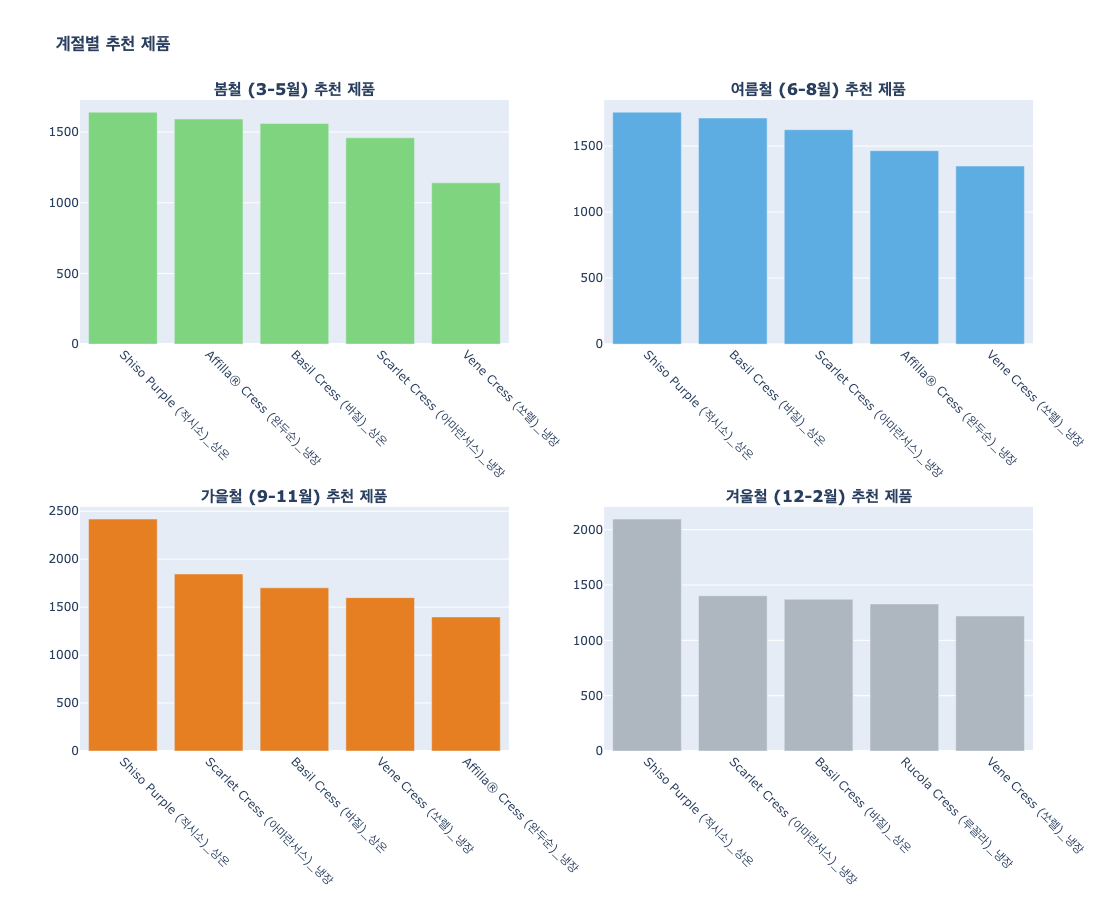


계절별 추천 제품 TOP 5:

봄철 (3-5월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 봄철 판매량: 1640.4개
2. Affilla® Cress (완두순)_냉장 - 봄철 판매량: 1592.2개
3. Basil Cress (바질)_상온 - 봄철 판매량: 1561.3개
4. Scarlet Cress (아마란서스)_냉장 - 봄철 판매량: 1459.3개
5. Vene Cress (쏘렐)_냉장 - 봄철 판매량: 1141.1개

여름철 (6-8월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 여름철 판매량: 1756.0개
2. Basil Cress (바질)_상온 - 여름철 판매량: 1712.0개
3. Scarlet Cress (아마란서스)_냉장 - 여름철 판매량: 1623.5개
4. Affilla® Cress (완두순)_냉장 - 여름철 판매량: 1464.5개
5. Vene Cress (쏘렐)_냉장 - 여름철 판매량: 1348.3개

가을철 (9-11월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 가을철 판매량: 2418.0개
2. Scarlet Cress (아마란서스)_냉장 - 가을철 판매량: 1845.5개
3. Basil Cress (바질)_상온 - 가을철 판매량: 1701.0개
4. Vene Cress (쏘렐)_냉장 - 가을철 판매량: 1599.0개
5. Affilla® Cress (완두순)_냉장 - 가을철 판매량: 1398.0개

겨울철 (12-2월) 추천 제품:
1. Shiso Purple (적시소)_상온 - 겨울철 판매량: 2096.0개
2. Scarlet Cress (아마란서스)_냉장 - 겨울철 판매량: 1403.0개
3. Basil Cress (바질)_상온 - 겨울철 판매량: 1371.0개
4. Rucola Cress (루꼴라)_냉장 - 겨울철 판매량: 1329.0개
5. Vene Cress (쏘렐)_냉장 - 겨울철 판매량: 1220.0개


In [292]:
def visualize_seasonal_recommendations():
    """계절별 추천 제품을 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    
    # 계절 정의 (봄: 3-5월, 여름: 6-8월, 가을: 9-11월, 겨울: 12-2월)
    spring_months = [3, 4, 5]
    summer_months = [6, 7, 8]
    autumn_months = [9, 10, 11]
    winter_months = [12, 1, 2]
    
    # 계절별 총 판매량이 높은 제품 파악
    seasonal_best = {}
    for product in pivot_table.index:
        spring_sales = sum([pivot_table.loc[product, m] for m in spring_months if m in pivot_table.columns])
        summer_sales = sum([pivot_table.loc[product, m] for m in summer_months if m in pivot_table.columns])
        autumn_sales = sum([pivot_table.loc[product, m] for m in autumn_months if m in pivot_table.columns])
        winter_sales = sum([pivot_table.loc[product, m] for m in winter_months if m in pivot_table.columns])
        
        total_sales = spring_sales + summer_sales + autumn_sales + winter_sales
        if total_sales > 10:  # 판매량이 일정 이상인 경우만 고려
            seasonal_best[product] = {
                '봄': spring_sales,
                '여름': summer_sales,
                '가을': autumn_sales,
                '겨울': winter_sales,
                '총판매량': total_sales
            }
    
    seasonal_df = pd.DataFrame(seasonal_best).T
    seasonal_df['주요계절'] = seasonal_df[['봄', '여름', '가을', '겨울']].idxmax(axis=1)
    
    # 계절별 상위 제품 추출
    spring_best = seasonal_df.sort_values('봄', ascending=False).head(5)
    summer_best = seasonal_df.sort_values('여름', ascending=False).head(5)
    autumn_best = seasonal_df.sort_values('가을', ascending=False).head(5)
    winter_best = seasonal_df.sort_values('겨울', ascending=False).head(5)
    
    # 계절별 색상 정의
    season_colors = {
        '봄': '#7FD47F',  # 밝은 녹색
        '여름': '#5DADE2',  # 하늘색
        '가을': '#E67E22',  # 주황색
        '겨울': '#AEB6BF'   # 회색빛 파랑
    }
    
    fig = make_subplots(rows=2, cols=2, subplot_titles=(
        "<b>봄철 (3-5월) 추천 제품</b>", 
        "<b>여름철 (6-8월) 추천 제품</b>", 
        "<b>가을철 (9-11월) 추천 제품</b>", 
        "<b>겨울철 (12-2월) 추천 제품</b>"
    ))
    
    # 봄철 상위 제품
    fig.add_trace(
        go.Bar(
            x=spring_best.index, 
            y=spring_best['봄'], 
            name="봄철 판매량",
            marker_color=season_colors['봄'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=1, col=1
    )
    
    # 여름철 상위 제품
    fig.add_trace(
        go.Bar(
            x=summer_best.index, 
            y=summer_best['여름'], 
            name="여름철 판매량",
            marker_color=season_colors['여름'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=1, col=2
    )
    
    # 가을철 상위 제품
    fig.add_trace(
        go.Bar(
            x=autumn_best.index, 
            y=autumn_best['가을'], 
            name="가을철 판매량",
            marker_color=season_colors['가을'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=2, col=1
    )
    
    # 겨울철 상위 제품
    fig.add_trace(
        go.Bar(
            x=winter_best.index, 
            y=winter_best['겨울'], 
            name="겨울철 판매량",
            marker_color=season_colors['겨울'],
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}</extra>'
        ),
        row=2, col=2
    )
    
    fig.update_layout(
        title_text="<b>계절별 추천 제품</b>",
        showlegend=False,
        width=1200,
        height=900
    )
    
    fig.update_xaxes(tickangle=45)
    fig.show()
    
    # 계절별 추천 제품 출력
    print("\n계절별 추천 제품 TOP 5:")
    
    print("\n봄철 (3-5월) 추천 제품:")
    for idx, (product, data) in enumerate(spring_best.iterrows(), 1):
        print(f"{idx}. {product} - 봄철 판매량: {data['봄']:.1f}개")
    
    print("\n여름철 (6-8월) 추천 제품:")
    for idx, (product, data) in enumerate(summer_best.iterrows(), 1):
        print(f"{idx}. {product} - 여름철 판매량: {data['여름']:.1f}개")
    
    print("\n가을철 (9-11월) 추천 제품:")
    for idx, (product, data) in enumerate(autumn_best.iterrows(), 1):
        print(f"{idx}. {product} - 가을철 판매량: {data['가을']:.1f}개")
    
    print("\n겨울철 (12-2월) 추천 제품:")
    for idx, (product, data) in enumerate(winter_best.iterrows(), 1):
        print(f"{idx}. {product} - 겨울철 판매량: {data['겨울']:.1f}개")

# 실행하면 이 그래프만 표시됨
visualize_seasonal_recommendations()


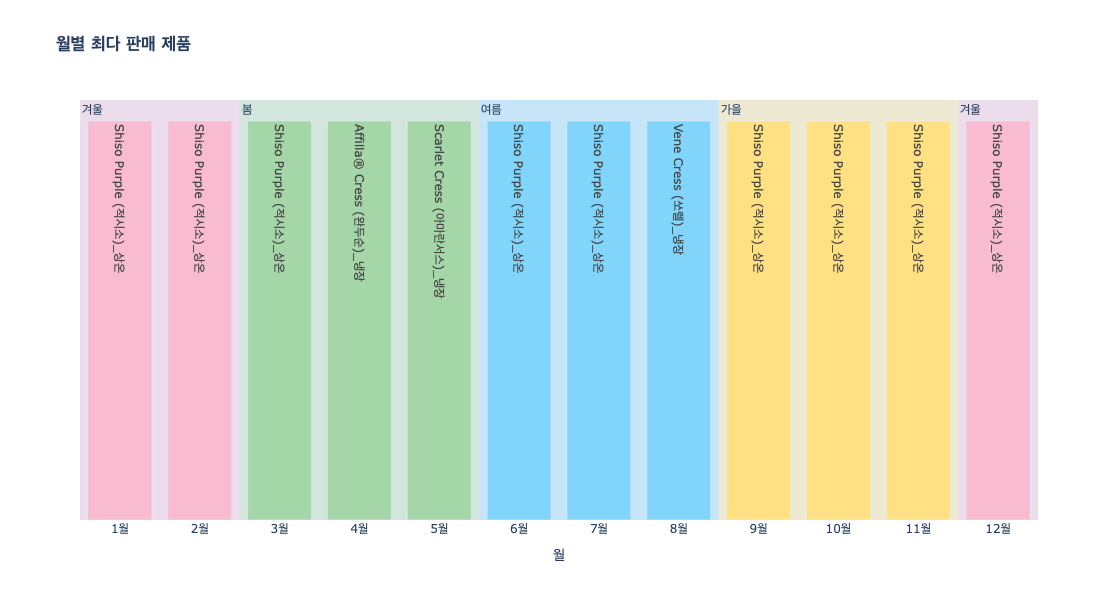

In [294]:
def visualize_monthly_best_products():
    """월별 최다 판매 제품을 시각화"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    
    monthly_best = {}
    for month in range(1, 13):
        if month in pivot_table.columns:
            monthly_best[month] = pivot_table[month].idxmax()
    
    monthly_best_df = pd.Series(monthly_best)
    
    # 월별 기본 색상 설정
    month_colors = [
        '#F8BBD0',  # 1월
        '#F8BBD0',  # 2월
        '#A5D6A7',  # 3월
        '#A5D6A7',  # 4월
        '#A5D6A7',  # 5월
        '#81D4FA',  # 6월
        '#81D4FA',  # 7월
        '#81D4FA',  # 8월
        '#FFE082',  # 9월
        '#FFE082',  # 10월
        '#FFE082',  # 11월
        '#F8BBD0',  # 12월
    ]
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=monthly_best_df.index,
        y=[1] * len(monthly_best_df),  # 높이 동일
        text=monthly_best_df.values,
        textposition='inside',
        marker_color=month_colors,
        hoverinfo='text',
        hovertext=[f"<b>{month}월 베스트 제품</b><br>{product}" for month, product in monthly_best_df.items()]
    ))
    
    # 계절 구분선 표시
    seasons = [
        {'name': '겨울', 'start': 0.5, 'end': 2.5, 'color': 'rgba(248, 187, 208, 0.3)'},
        {'name': '봄', 'start': 2.5, 'end': 5.5, 'color': 'rgba(165, 214, 167, 0.3)'},
        {'name': '여름', 'start': 5.5, 'end': 8.5, 'color': 'rgba(129, 212, 250, 0.3)'},
        {'name': '가을', 'start': 8.5, 'end': 11.5, 'color': 'rgba(255, 224, 130, 0.3)'},
        {'name': '겨울', 'start': 11.5, 'end': 12.5, 'color': 'rgba(248, 187, 208, 0.3)'}
    ]
    
    for season in seasons:
        fig.add_vrect(
            x0=season['start'], x1=season['end'],
            fillcolor=season['color'],
            layer="below", line_width=0,
            annotation_text=season['name'],
            annotation_position="top left"
        )
    
    fig.update_layout(
        title="<b>월별 최다 판매 제품</b>",
        xaxis_title="월",
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 13)),
            ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        ),
        yaxis=dict(visible=False),
        width=1100,
        height=600
    )
    
    fig.show()

# 실행하면 이 그래프만 표시됨
visualize_monthly_best_products()


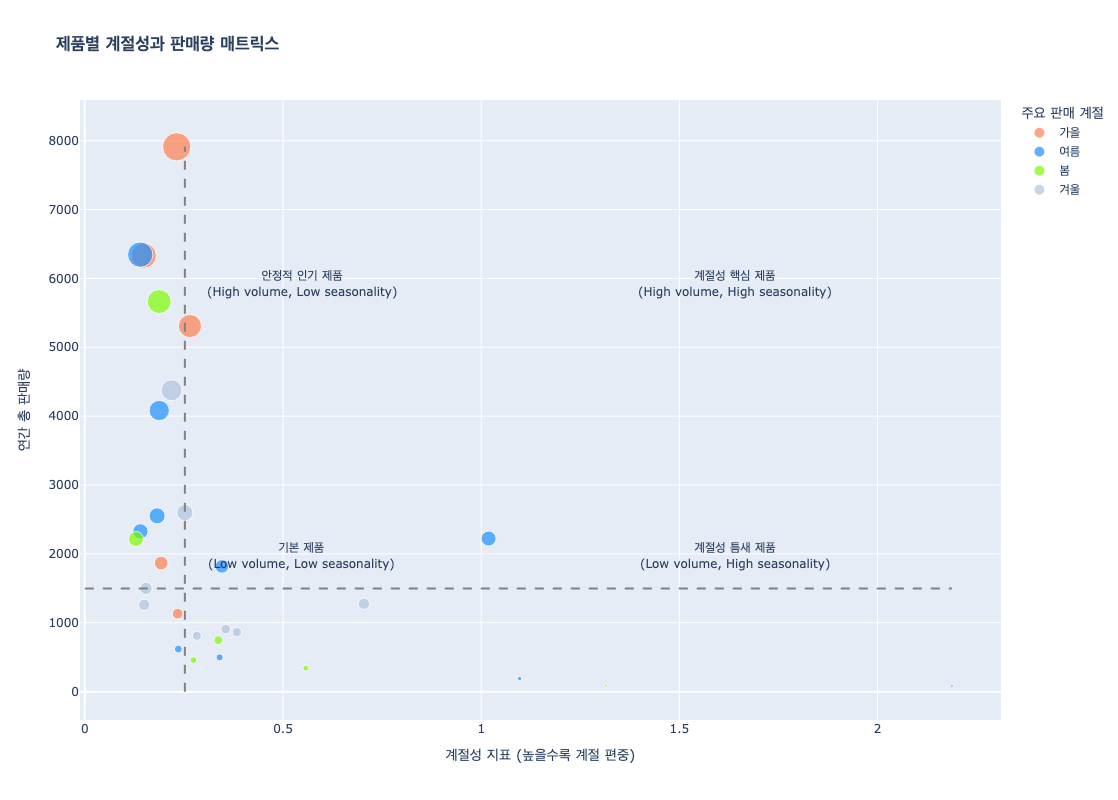


제품 계절성 분석 결과:

계절성이 높은 핵심 판매 제품 (총 3개):
   1. Zorri Cress (한련화)_냉장 - 계절성 지표: 1.02, 총 판매량: 2223개, 주요 계절: 여름
   2. Mizuna Cress (경수채)_냉장 - 계절성 지표: 0.35, 총 판매량: 1818개, 주요 계절: 여름
   3. Vene Cress (쏘렐)_냉장 - 계절성 지표: 0.27, 총 판매량: 5308개, 주요 계절: 가을


In [296]:
def visualize_product_seasonality_matrix():
    """제품의 계절성과 판매량을 동시에 시각화하는 산점도 매트릭스"""
    data = prepare_monthly_product_data()
    pivot_table = data['pivot_table']
    
    # 계절성 계산
    def calculate_seasonality(sales_array):
        """판매량 배열에서 계절성 지표 계산 (표준편차/평균)"""
        if np.mean(sales_array) > 0:
            return np.std(sales_array) / (np.mean(sales_array) + 1)
        else:
            return 0
    
    # 총 판매량과 계절성 계산
    product_metrics = []
    for product in pivot_table.index:
        monthly_sales = pivot_table.loc[product].values
        total_sales = np.sum(monthly_sales)
        
        # 판매량이 일정 이상인 제품만 고려
        if total_sales > 20:
            seasonality = calculate_seasonality(monthly_sales)
            peak_month = pivot_table.loc[product].idxmax()  # 최대 판매월
            product_metrics.append({
                '제품': product, 
                '계절성_지표': seasonality, 
                '최대_판매월': peak_month,
                '총_판매량': total_sales
            })
    
    # 데이터프레임 생성
    metrics_df = pd.DataFrame(product_metrics).sort_values('총_판매량', ascending=False).head(40)
    
    # 주요 계절 결정
    seasons = {
        '봄': [3, 4, 5],
        '여름': [6, 7, 8],
        '가을': [9, 10, 11],
        '겨울': [12, 1, 2]
    }
    
    # 각 제품의 주요 계절 파악
    main_seasons = []
    for _, row in metrics_df.iterrows():
        product = row['제품']
        max_seasonal_sales = 0
        main_season = "미정"
        
        for season, months in seasons.items():
            seasonal_sales = sum([pivot_table.loc[product, m] for m in months if m in pivot_table.columns])
            if seasonal_sales > max_seasonal_sales:
                max_seasonal_sales = seasonal_sales
                main_season = season
        
        main_seasons.append(main_season)
    
    metrics_df['주요_계절'] = main_seasons
    
    # 계절별 색상 매핑
    season_colors = {
        '봄': 'rgb(124, 252, 0)',     # 라임 그린
        '여름': 'rgb(30, 144, 255)',   # 도지 블루
        '가을': 'rgb(255, 127, 80)',   # 코럴
        '겨울': 'rgb(176, 196, 222)',  # 라이트 스틸 블루
        '미정': 'rgb(128, 128, 128)'   # 그레이
    }
    
    # 산점도 매트릭스 생성
    fig = px.scatter(
        metrics_df, 
        x='계절성_지표', 
        y='총_판매량', 
        size='총_판매량',
        color='주요_계절',
        color_discrete_map=season_colors,
        hover_name='제품',
        hover_data={
            '계절성_지표': ':.2f',
            '총_판매량': ':.1f',
            '최대_판매월': True,
            '주요_계절': True
        },
        labels={
            '계절성_지표': '계절성 지표 (높을수록 계절 편중)',
            '총_판매량': '연간 총 판매량',
            '최대_판매월': '최대 판매월',
            '주요_계절': '주요 판매 계절'
        },
        title='<b>제품별 계절성과 판매량 매트릭스</b>'
    )
    
    # 산점도 사분면을 구분하는 레퍼런스 라인 추가
    median_seasonality = metrics_df['계절성_지표'].median()
    median_sales = metrics_df['총_판매량'].median()
    
    fig.add_shape(
        type='line',
        x0=median_seasonality, x1=median_seasonality,
        y0=0, y1=metrics_df['총_판매량'].max(),
        line=dict(color='gray', dash='dash')
    )
    
    fig.add_shape(
        type='line',
        x0=0, x1=metrics_df['계절성_지표'].max(),
        y0=median_sales, y1=median_sales,
        line=dict(color='gray', dash='dash')
    )
    
    # 사분면 레이블 추가
    fig.add_annotation(
        x=metrics_df['계절성_지표'].max() * 0.25,
        y=metrics_df['총_판매량'].max() * 0.75,
        text="안정적 인기 제품<br>(High volume, Low seasonality)",
        showarrow=False,
        font=dict(size=12)
    )
    
    fig.add_annotation(
        x=metrics_df['계절성_지표'].max() * 0.75,
        y=metrics_df['총_판매량'].max() * 0.75,
        text="계절성 핵심 제품<br>(High volume, High seasonality)",
        showarrow=False,
        font=dict(size=12)
    )
    
    fig.add_annotation(
        x=metrics_df['계절성_지표'].max() * 0.25,
        y=metrics_df['총_판매량'].max() * 0.25,
        text="기본 제품<br>(Low volume, Low seasonality)",
        showarrow=False,
        font=dict(size=12)
    )
    
    fig.add_annotation(
        x=metrics_df['계절성_지표'].max() * 0.75,
        y=metrics_df['총_판매량'].max() * 0.25,
        text="계절성 틈새 제품<br>(Low volume, High seasonality)",
        showarrow=False,
        font=dict(size=12)
    )
    
    fig.update_layout(width=1200, height=800)
    fig.show()
    
    # 분석 결과 요약
    print("\n제품 계절성 분석 결과:")
    
    high_seasonality = metrics_df[metrics_df['계절성_지표'] > median_seasonality]
    high_volume_high_seasonality = high_seasonality[high_seasonality['총_판매량'] > median_sales]
    
    print(f"\n계절성이 높은 핵심 판매 제품 (총 {len(high_volume_high_seasonality)}개):")
    for i, (_, row) in enumerate(high_volume_high_seasonality.sort_values('계절성_지표', ascending=False).head(5).iterrows(), 1):
        print(f"   {i}. {row['제품']} - 계절성 지표: {row['계절성_지표']:.2f}, 총 판매량: {row['총_판매량']:.0f}개, 주요 계절: {row['주요_계절']}")

# 실행하면 이 그래프만 표시됨
visualize_product_seasonality_matrix()



월별 판매 패턴 분석 결과:
  - 최대 판매 월: 12.0월 (총 6706.0개)
  - 최소 판매 월: 2.0월 (총 4461.0개)
  - 최대/최소 판매 월 비율: 1.5배


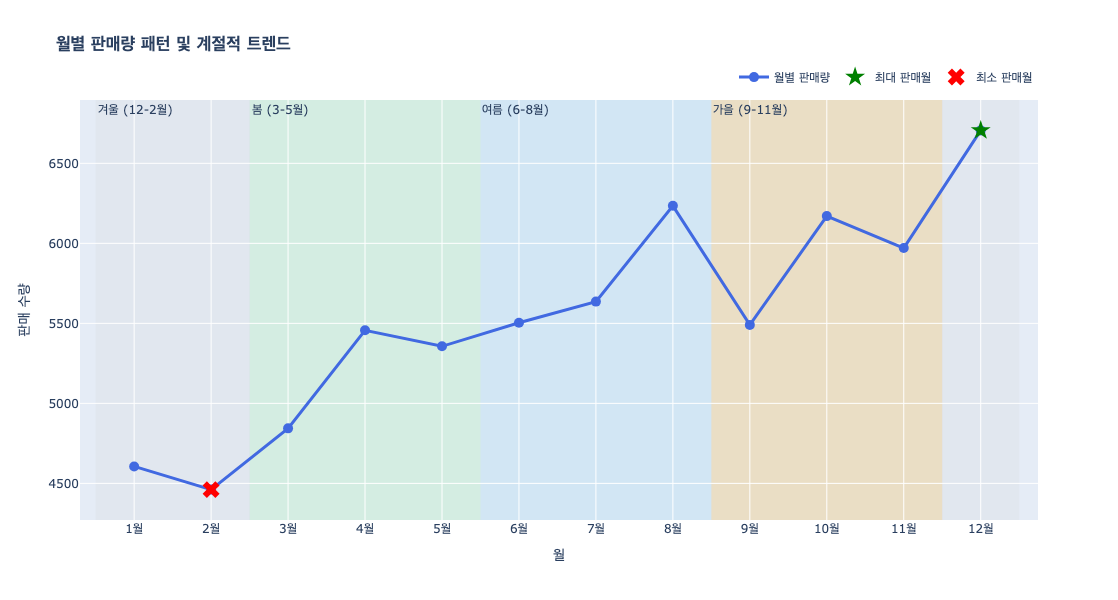

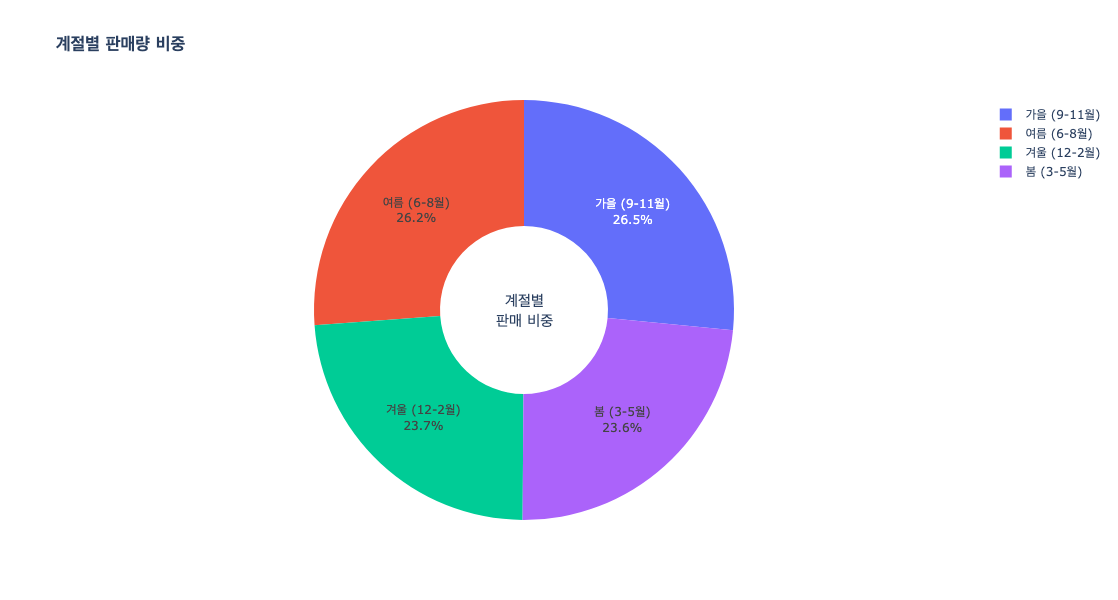

In [298]:
def visualize_monthly_pattern_insights():
    """월별 판매 패턴에서 핵심 인사이트 도출 및 시각화"""
    monthly_total = sales_data.groupby('month')['수량'].sum()
    
    # 데이터가 비어있지 않은 경우에만 처리
    if not monthly_total.empty:
        max_month = monthly_total.idxmax()
        min_month = monthly_total.idxmin()
        
        # 계절별 총 판매량 계산
        seasons = {
            '봄 (3-5월)': [3, 4, 5],
            '여름 (6-8월)': [6, 7, 8],
            '가을 (9-11월)': [9, 10, 11],
            '겨울 (12-2월)': [12, 1, 2]
        }
        
        seasonal_sales = {}
        for season, months in seasons.items():
            seasonal_sales[season] = sum([monthly_total[m] if m in monthly_total.index else 0 for m in months])
        
        # 분석 결과 출력
        print(f"\n월별 판매 패턴 분석 결과:")
        print(f"  - 최대 판매 월: {max_month}월 (총 {monthly_total[max_month]:.1f}개)")
        print(f"  - 최소 판매 월: {min_month}월 (총 {monthly_total[min_month]:.1f}개)")
        print(f"  - 최대/최소 판매 월 비율: {monthly_total[max_month] / monthly_total[min_month]:.1f}배")
        
        # 월별 판매량 추이 시각화
        fig = go.Figure()
        
        # 월별 판매량 추이
        fig.add_trace(go.Scatter(
            x=list(range(1, 13)),
            y=[monthly_total[m] if m in monthly_total.index else 0 for m in range(1, 13)],
            mode='lines+markers',
            name='월별 판매량',
            line=dict(color='royalblue', width=3),
            marker=dict(size=10),
            hovertemplate='<b>%{y:.1f}개</b><extra>%{x}월</extra>'
        ))
        
        # 최대/최소 판매월 강조
        fig.add_trace(go.Scatter(
            x=[max_month],
            y=[monthly_total[max_month]],
            mode='markers',
            name='최대 판매월',
            marker=dict(color='green', size=15, symbol='star'),
            hovertemplate='<b>최대 판매월: %{x}월</b><br>판매량: %{y:.1f}개<extra></extra>'
        ))
        
        fig.add_trace(go.Scatter(
            x=[min_month],
            y=[monthly_total[min_month]],
            mode='markers',
            name='최소 판매월',
            marker=dict(color='red', size=15, symbol='x'),
            hovertemplate='<b>최소 판매월: %{x}월</b><br>판매량: %{y:.1f}개<extra></extra>'
        ))
        
        # 계절 구분용 배경 색상 추가
        season_colors = {
            '봄 (3-5월)': 'rgba(144, 238, 144, 0.2)',  # 연한 녹색
            '여름 (6-8월)': 'rgba(135, 206, 235, 0.2)',  # 연한 하늘색
            '가을 (9-11월)': 'rgba(255, 165, 0, 0.2)',   # 연한 주황색
            '겨울 (12-2월)': 'rgba(211, 211, 211, 0.2)'  # 연한 회색
        }
        
        # 계절 배경 추가
        for season, months in seasons.items():
            # 12월은 x축 값 조정이 필요
            if season == '겨울 (12-2월)':
                fig.add_vrect(
                    x0=0.5,  # 12월 이전
                    x1=2.5,  # 2월 이후
                    fillcolor=season_colors[season],
                    layer="below",
                    line_width=0,
                    annotation_text=season,
                    annotation_position="top left"
                )
                # 12월 구간 추가
                fig.add_vrect(
                    x0=11.5,  # 11월 이후
                    x1=12.5,  # 12월 포함
                    fillcolor=season_colors[season],
                    layer="below",
                    line_width=0,
                )
            else:
                min_month_idx = min(months)
                max_month_idx = max(months)
                fig.add_vrect(
                    x0=min_month_idx - 0.5,
                    x1=max_month_idx + 0.5,
                    fillcolor=season_colors[season],
                    layer="below",
                    line_width=0,
                    annotation_text=season,
                    annotation_position="top left"
                )
        
        fig.update_layout(
            title='<b>월별 판매량 패턴 및 계절적 트렌드</b>',
            xaxis_title='월',
            yaxis_title='판매 수량',
            xaxis=dict(
                tickmode='array',
                tickvals=list(range(1, 13)),
                ticktext=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
            ),
            hovermode='closest',
            width=1200,
            height=600,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        
        fig.show()
        
        # 계절별 판매량 비교 (파이 차트) - 별도 차트로 분리
        labels = list(seasonal_sales.keys())
        values = list(seasonal_sales.values())
        
        fig2 = go.Figure(data=[go.Pie(
            labels=labels, 
            values=values,
            hole=.4,
            textinfo='label+percent',
            hovertemplate='<b>%{label}</b><br>판매량: %{value:.1f}개<br>비중: %{percent}<extra></extra>'
        )])
        
        fig2.update_layout(
            title='<b>계절별 판매량 비중</b>',
            width=800,
            height=600,
            annotations=[dict(text='계절별<br>판매 비중', x=0.5, y=0.5, font_size=15, showarrow=False)]
        )
        
        fig2.show()
    else:
        print("월별 판매 데이터가 없습니다.")

# 실행하면 이 그래프만 표시됨 (두 개의 그래프가 연속으로 표시됨)
visualize_monthly_pattern_insights()
